## Trip segments list
* Generating a dataset with all trip segments
* Let's know their stat distributions and filter trips with strange values

Libraries

In [45]:
import pandas as pd
import json
from haversine import haversine, Unit
import gc
from matplotlib import pyplot as plt

from yellow import trips as yt
from yellow import trajectories as traj

Trips

In [2]:
trips = pd.read_csv('~/saida.csv')
len(trips)

427026

Extracting segments

In [3]:
trip_count = 0
INSTANT = 0
LAT = 1
LONG = 2

def separate_segments(row):
    global trip_count
        
    timestamps = json.loads(row.timestamps)
    lats = json.loads(row.lats)
    longs = json.loads(row.longs)
    points = zip(timestamps, lats, longs)
    ant = next(points)
    segno = 0
    
    for point in points:
        segno += 1
        distance = haversine((ant[LAT], ant[LONG]), (point[LAT], point[LONG]), unit=Unit.METERS)
        duration = point[INSTANT] - ant[INSTANT]
        speed = distance / duration * 3.6
        f_segments.write('{},{},{},{},{}\n'.format(row.tripid, segno, distance, duration, speed))
        ant = point
        
    trip_count += 1
    if trip_count % 1000 == 0: print(trip_count, segno)

#f_segments = open('/home/ederson/trip-segments.csv', 'w')
#f_segments.write('tripid,segno,duration,distance,speed\n')
#trips.apply(separate_segments, axis=1, result_type='expand')
#f_segments.close()

In [4]:
# previously calculated file
segments = pd.read_csv('~/trip-segments.csv')  # 4.3G!

In [5]:
len(segments)

42338712

Durations and distances

In [6]:
segments.duration.describe()

count    4.233871e+07
mean     6.840770e+01
std      2.159118e+04
min      0.000000e+00
25%      3.898355e-01
50%      7.797323e+00
75%      1.929275e+01
max      1.477037e+07
Name: duration, dtype: float64

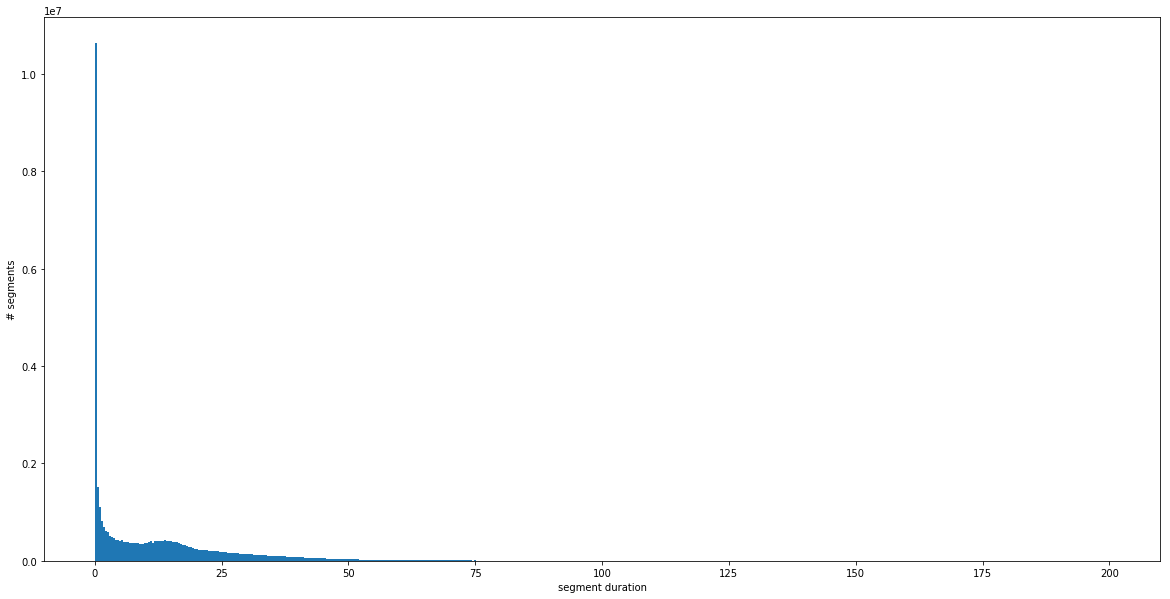

In [7]:
stat = segments.duration
plt.figure(figsize=(20, 10))
plt.xlabel('segment duration')
plt.ylabel('# segments')
plt.hist(stat[stat < 200], bins=500)
plt.show()

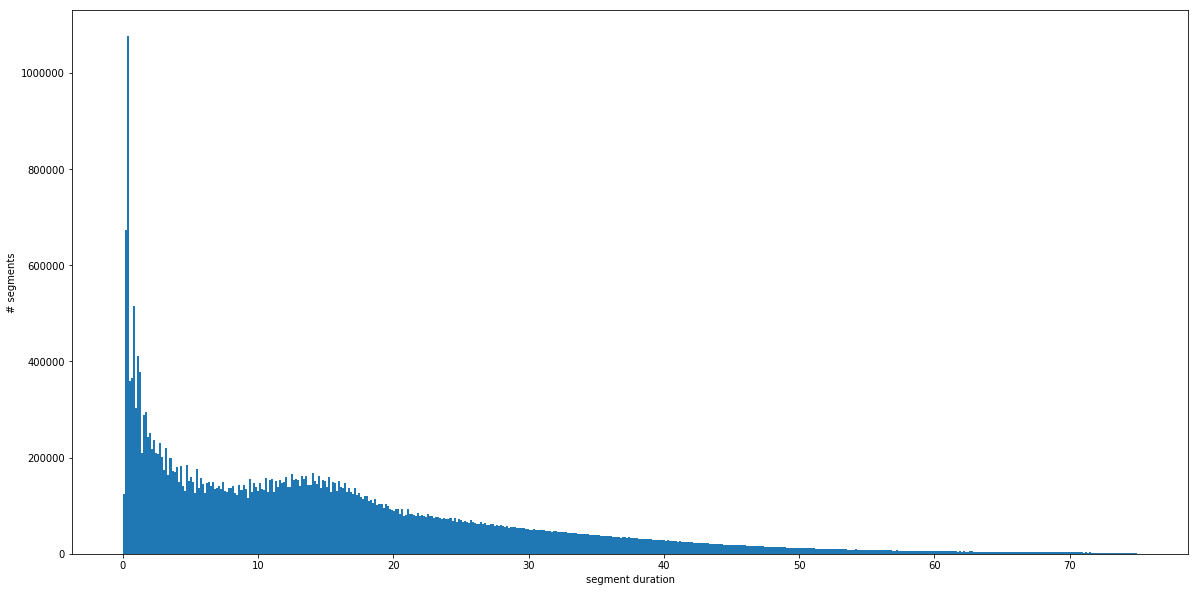

In [8]:
stat = segments.duration
plt.figure(figsize=(20, 10))
plt.xlabel('segment duration')
plt.ylabel('# segments')
plt.hist(stat[(stat > 0) & (stat < 75)], bins=500)
plt.show()

In [9]:
segments.distance.describe()

count    4.233871e+07
mean     8.351687e+00
std      7.615465e+02
min      9.999275e-04
25%      4.980000e+00
50%      5.005000e+00
75%      7.121000e+00
max      2.150238e+06
Name: distance, dtype: float64

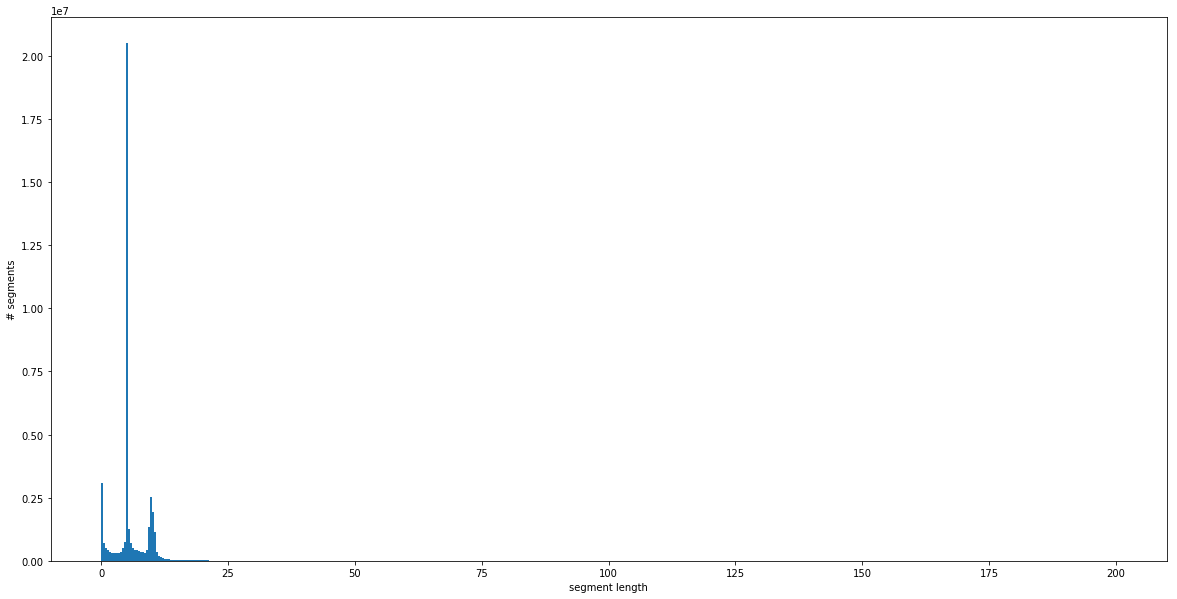

In [10]:
stat = segments.distance
plt.figure(figsize=(20, 10))
plt.xlabel('segment length')
plt.ylabel('# segments')
plt.hist(stat[stat < 200], bins=500)
plt.show()

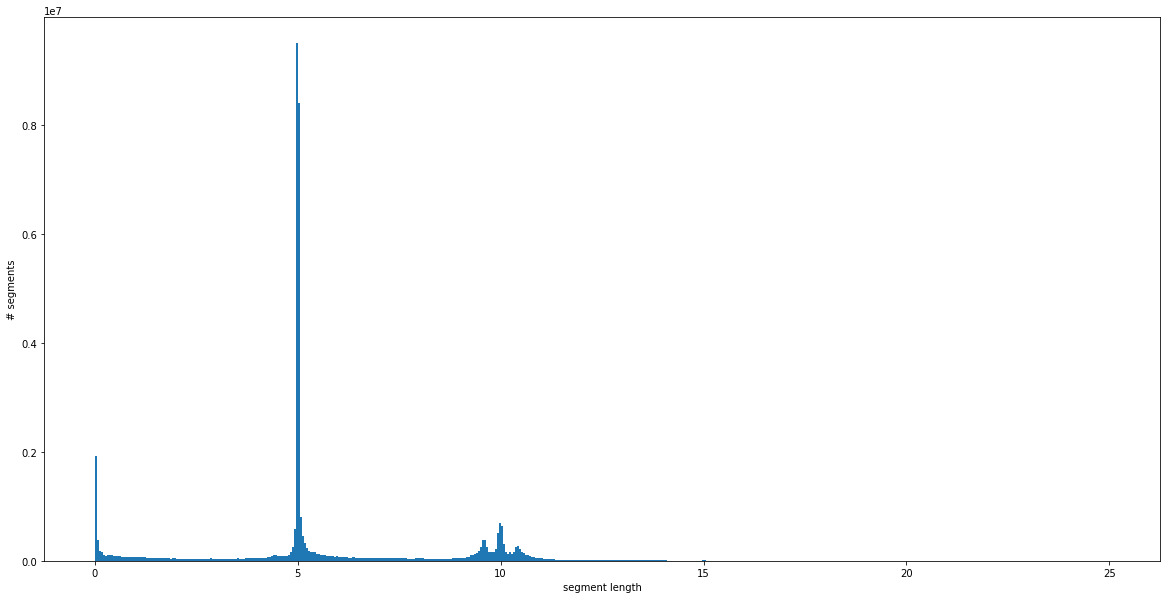

In [11]:
stat = segments.distance
plt.figure(figsize=(20, 10))
plt.xlabel('segment length')
plt.ylabel('# segments')
plt.hist(stat[(stat > 0) & (stat < 25)], bins=500)
plt.show()

In [12]:
segments.speed.describe()

count    4.233871e+07
mean     1.464212e+02
std      1.134305e+05
min      0.000000e+00
25%      2.794612e-01
50%      5.285257e+00
75%      1.175698e+01
max      6.574939e+08
Name: speed, dtype: float64

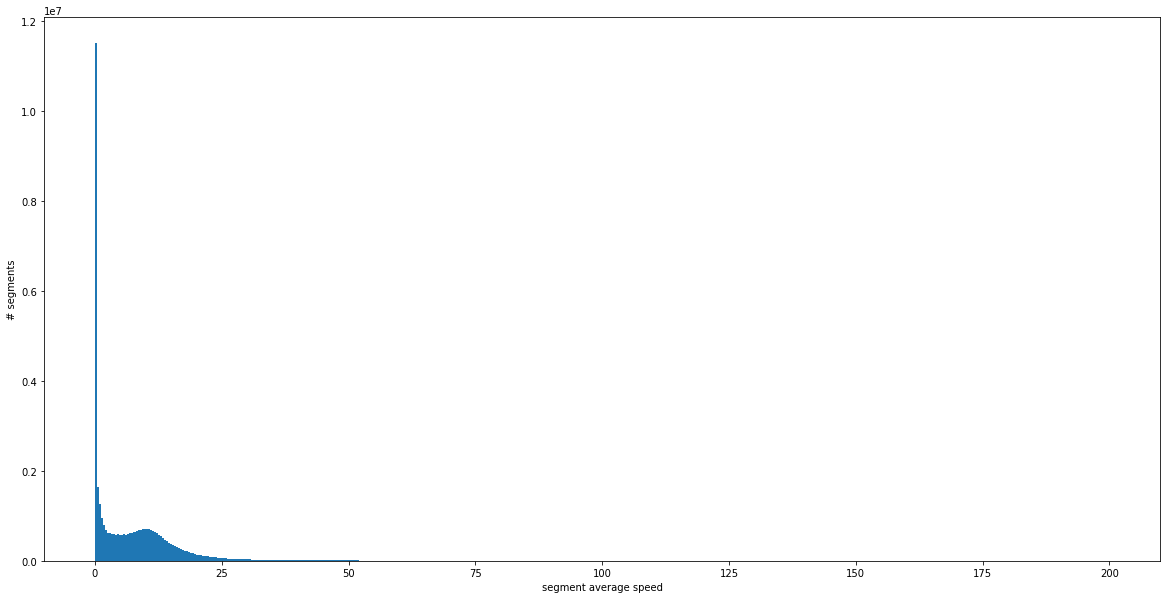

In [13]:
stat = segments.speed
plt.figure(figsize=(20, 10))
plt.xlabel('segment average speed')
plt.ylabel('# segments')
plt.hist(stat[stat < 200], bins=500)
plt.show()

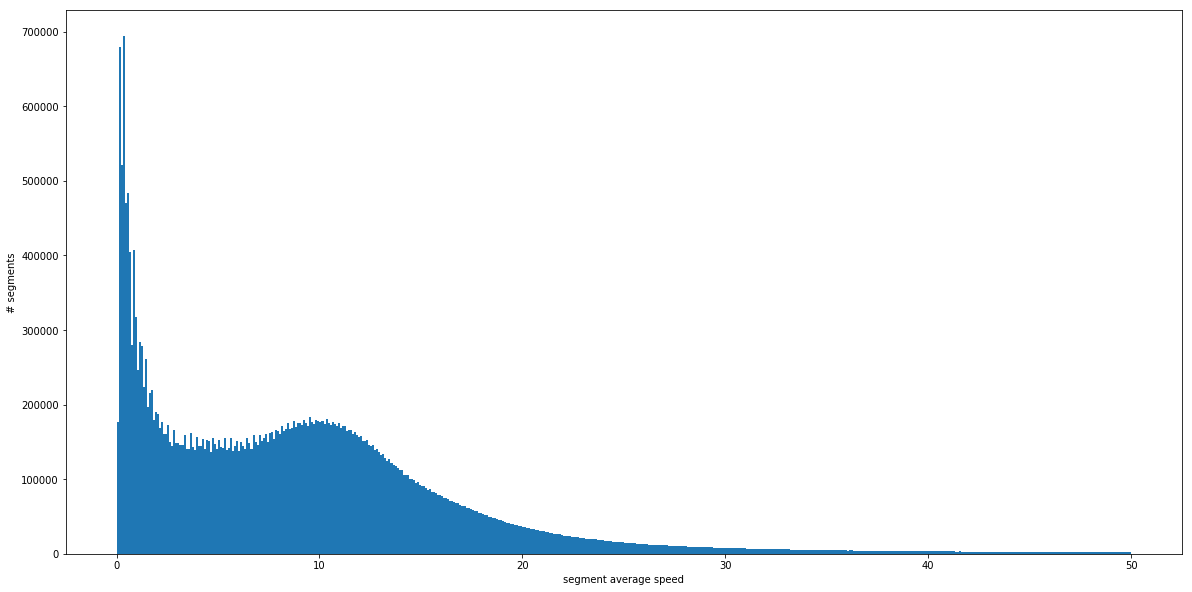

In [14]:
stat = segments.speed
plt.figure(figsize=(20, 10))
plt.xlabel('segment average speed')
plt.ylabel('# segments')
plt.hist(stat[(stat > 0) & (stat < 50)], bins=500)
plt.show()

Categorizing
* Convention: `(distance)_(duration)`
* Types: `zero`, `normal`, `long`
* Examples: `normal_zero`, `long_normal`

In [15]:
dist_thresholds = [0, 11, float('inf')]
dur_thresholds = [0, 75, float('inf')]
filters = {}
total = 0

dist_min = -1
for dist_max in dist_thresholds:
    print(']{}, {}]m'.format(dist_min, dist_max))
    filters[(dist_min, dist_max)] = {}
    dur_min = -1
    for dur_max in dur_thresholds:
        print('   ]{}, {}]s'.format(dur_min, dur_max), end=': ')
        filtered = segments[(segments.distance > dist_min) & (segments.distance <= dist_max) &
                            (segments.duration > dur_min) & (segments.duration <= dur_max)]
        print('   {} ({:.3f}%)'.format(len(filtered), len(filtered) / len(segments) * 100))
        total += len(filtered)
        filters[(dist_min, dist_max)][(dur_min, dur_max)] = filtered
        dur_min = dur_max
    print()
    dist_min = dist_max

assert total == len(segments)

]-1, 0]m
   ]-1, 0]s:    0 (0.000%)
   ]0, 75]s:    0 (0.000%)
   ]75, inf]s:    0 (0.000%)

]0, 11]m
   ]-1, 0]s:    9231964 (21.805%)
   ]0, 75]s:    31008797 (73.240%)
   ]75, inf]s:    566382 (1.338%)

]11, inf]m
   ]-1, 0]s:    203553 (0.481%)
   ]0, 75]s:    1162641 (2.746%)
   ]75, inf]s:    165375 (0.391%)



In [16]:
normal_zero = filters[(0, 11)][(-1, 0)]
len(normal_zero)

9231964

In [17]:
normal_zero_trips = pd.DataFrame(index=normal_zero.tripid.unique(), data={'normal_zero': True})
print(len(normal_zero_trips))
normal_zero_trips.head()

277730


normal_zero
490874f66a03bc9512ade8a664a19c812c3567714849ec4...         True
e6bdd74812591cbbd0c6e4ee94fc9d75103f2e59e93a338...         True
fb191af99dd30d28e8902804c64a3f84d4f3c178bab3108...         True
c59ac2e69f1ff693f3612ac7278a17db011e0cae19d11f7...         True
99a95af0f74e39c161f2e0110b14ce4797d09da20d4c24e...         True

In [18]:
normal_normal = filters[(0, 11)][(0, 75)]
len(normal_normal)

31008797

In [19]:
normal_normal_trips = pd.DataFrame(index=normal_normal.tripid.unique(), data={'normal_normal': True})
print(len(normal_normal_trips))
normal_normal_trips.head()

342213


normal_normal
daadf046a3b54be5dfa3885ae8e91b416d301b8c2cdd6ee...           True
8e689f3fe4ecabd9fdb7d02729acaa72e780bf07da8ef80...           True
7694ad8126d5ec694a0f0054e349cedea97a827c222547e...           True
dd184b9a563f53aec80b4527549a01423ee39f9a442f2f1...           True
df7cbc056650daa33f5a674e741ff0662298320e05fafef...           True

In [20]:
normal_long = filters[(0, 11)][(75, float('inf'))]
len(normal_long)

566382

In [21]:
normal_long_trips = pd.DataFrame(index=normal_long.tripid.unique(), data={'normal_long': True})
print(len(normal_long_trips))
normal_long_trips.head()

86975


normal_long
e4ae888de94722d8599edc4c5758043fc1fcc574ea1c635...         True
dd22e79291b4284de8d328ebe57f10b15f85204b8aaf47a...         True
1367ac4303fc5159f753d65dcc8a9242eb10e73568ff0d5...         True
9965c10e6635835c8d5e062c3fa33e30ff1f3baac12cedc...         True
6832c1ff9184f8a40e0a4d159f18383a31c375a0054b1c5...         True

In [22]:
long_zero = filters[(11, float('inf'))][(-1, 0)]
len(long_zero)

203553

In [23]:
long_zero_trips = pd.DataFrame(index=long_zero.tripid.unique(), data={'long_zero': True})
print(len(long_zero_trips))
long_zero_trips.head()

60608


long_zero
fb191af99dd30d28e8902804c64a3f84d4f3c178bab3108...       True
7bfa49a3192eb9a62f4c1d2a9f3a8b5a50d79c5f4ec0fde...       True
ce0f38562c5b838a9033d3c1da391041fe27bed2c4cf0e7...       True
6832c1ff9184f8a40e0a4d159f18383a31c375a0054b1c5...       True
79fed5678819ee9f2abe4e726ce3775f43c1475357a44fa...       True

In [24]:
long_normal = filters[(11, float('inf'))][(0, 75)]
len(long_normal)

1162641

In [25]:
long_normal_trips = pd.DataFrame(index=long_normal.tripid.unique(), data={'long_normal': True})
print(len(long_normal_trips))
long_normal_trips.head()

178642


long_normal
9110e0bb08e219f66f441faf4704e6598a167746a4ec133...         True
474b90cbd2dc59e49287037badb848dd2b513c23e3a97a3...         True
36d3ddc2c8f9bfce2551144fb38455828ffca49b6c546a7...         True
f095cf5d10fddb18f71bd0a46fbd56e8ddffbd5e95167f8...         True
0aaaa2f9f80f7de5971b04d38557a1d561fa2905b6e34be...         True

In [26]:
long_long = filters[(11, float('inf'))][(75, float('inf'))]
len(long_long)

165375

In [27]:
long_long_trips = pd.DataFrame(index=long_long.tripid.unique(), data={'long_long': True})
print(len(long_long_trips))
long_long_trips.head()

71182


long_long
d08014216522750978369a29ac73e9c5e840e50aa913e1e...       True
e4ae888de94722d8599edc4c5758043fc1fcc574ea1c635...       True
8890c26789e47e3e56b40b724d804f8f1b3ef75f753e481...       True
ce0f38562c5b838a9033d3c1da391041fe27bed2c4cf0e7...       True
1367ac4303fc5159f753d65dcc8a9242eb10e73568ff0d5...       True

In [28]:
trip_segment_types = normal_zero_trips \
                     .join(normal_normal_trips) \
                     .join(normal_long_trips) \
                     .join(long_zero_trips) \
                     .join(long_normal_trips) \
                     .join(long_long_trips) \
                     .fillna(False)
trip_segment_types.reset_index(inplace=True)
trip_segment_types.rename(columns={'index': 'tripid'}, inplace=True)
print(len(trip_segment_types))
trip_segment_types.head()

277730


tripid  normal_zero  \
0  490874f66a03bc9512ade8a664a19c812c3567714849ec...         True   
1  e6bdd74812591cbbd0c6e4ee94fc9d75103f2e59e93a33...         True   
2  fb191af99dd30d28e8902804c64a3f84d4f3c178bab310...         True   
3  c59ac2e69f1ff693f3612ac7278a17db011e0cae19d11f...         True   
4  99a95af0f74e39c161f2e0110b14ce4797d09da20d4c24...         True   

   normal_normal  normal_long  long_zero  long_normal  long_long  
0           True        False      False         True      False  
1           True        False      False         True      False  
2           True        False       True         True      False  
3          False        False      False        False      False  
4           True        False      False        False      False

In [29]:
trip_segment_types.to_csv('~/trip-segment-types.csv')

In [30]:
len(trip_segment_types) / len(trips)

0.6503819439565741

In [49]:
category_fields = ['normal_zero', 'normal_normal', 'normal_long', 'long_zero', 'long_normal', 'long_long']
categories = trip_segment_types.groupby(category_fields, as_index=False).agg({'tripid': 'count'})
categories.reset_index(inplace=True)
categories.rename(columns={'index': 'category', 'tripid': 'countings'}, inplace=True)
categories

category  normal_zero  normal_normal  normal_long  long_zero  long_normal  \
0          0         True          False        False      False        False   
1          1         True          False        False      False        False   
2          2         True          False        False      False         True   
3          3         True          False        False      False         True   
4          4         True          False        False       True        False   
5          5         True          False        False       True        False   
6          6         True          False        False       True         True   
7          7         True          False        False       True         True   
8          8         True          False         True      False        False   
9          9         True          False         True      False        False   
10        10         True          False         True      False         True   
11        11         True          False         True      False         True   
12        12         True          False         True       True        False   
13        13         True          False         True       True        False   
14        14         True          False         True       True         True   
15        15         True          False         True       True         True   
16        16         True           True        False      False        False   
17        17         True           True        False      False        False   
18        18         True           True        False      False         True   
19        19         True           True        False      False         True   
20        20         True           True        False       True        False   
21        21         True           True        False       True        False   
22        22         True           True        False       True         True   
23        23         True           True        False       True         True   
24        24         True           True         True      False        False   
25        25         True           True         True      False        False   
26        26         True           True         True      False         True   
27        27         True           True         True      False         True   
28        28         True           True         True       True        False   
29        29         True           True         True       True        False   
30        30         True           True         True       True         True   
31        31         True           True         True       True         True   

    long_long  countings  
0       False      24574  
1        True       1156  
2       False        860  
3        True        145  
4       False       6301  
5        True        283  
6       False        202  
7        True         49  
8       False        359  
9        True        146  
10      False         39  
11       True         25  
12      False         75  
13       True         96  
14      False          9  
15       True         29  
16      False      69495  
17       True       9433  
18      False      48395  
19       True      13312  
20      False       8717  
21       True       1992  
22      False      10524  
23       True       5815  
24      False      22372  
25       True       3585  
26      False      16877  
27       True      10637  
28      False       3992  
29       True       1822  
30      False       5510  
31       True      10904

Trip stats

In [66]:
cities = pd.read_csv('~/cities.csv')
stats = pd.read_csv('~/traj-stats.csv')
trips = trips.merge(cities[cities.city == 'São Paulo'], on='tripid').merge(stats, on='tripid')
trips['avg_speed'] = trips.total_distance / trips.total_duration * 3.6
trips['start_time'] = yt.extract_start_times(trips)

Finally inspecting


--- CATEGORY: 0


count    21878.000000
mean        30.514584
std         33.532963
min          0.001000
25%         10.297500
50%         30.012500
75%         49.360750
max       1404.886000
Name: total_duration, dtype: float64

count    21878.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: total_distance, dtype: float64

count    21878.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: avg_speed, dtype: float64

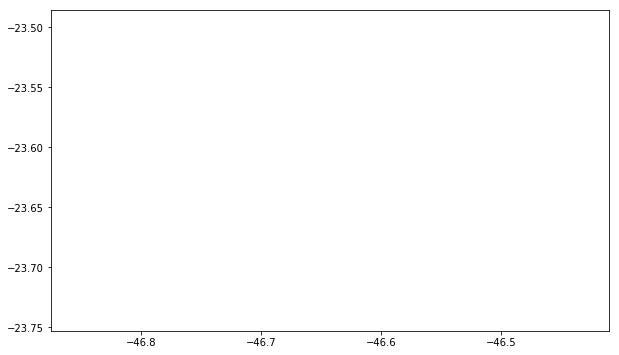

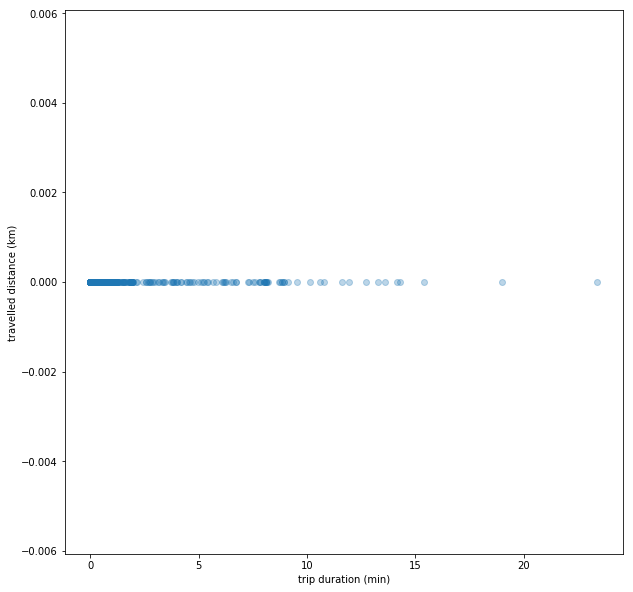


--- CATEGORY: 1


count      981.000000
mean      1024.774608
std       1567.231381
min         14.511000
25%        315.018000
50%        561.298000
75%       1216.952000
max      26237.010000
Name: total_duration, dtype: float64

count      981.000000
mean      1280.520101
std       1994.252443
min         75.372757
25%        424.963623
50%        799.902556
75%       1431.349173
max      25764.293528
Name: total_distance, dtype: float64

count     981.000000
mean        8.702728
std        43.620498
min         0.077111
25%         3.281922
50%         6.162391
75%         8.527625
max      1230.126034
Name: avg_speed, dtype: float64

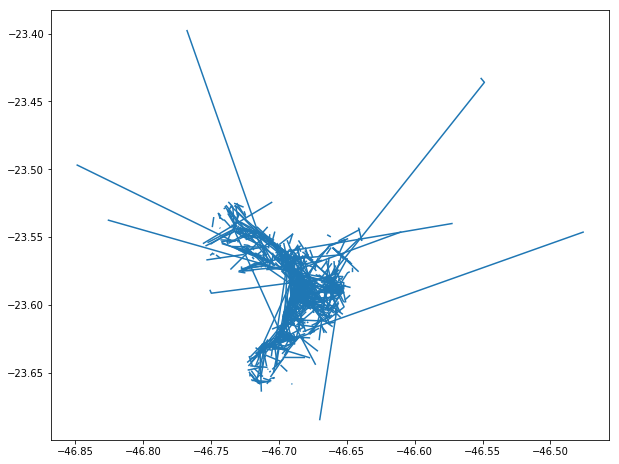

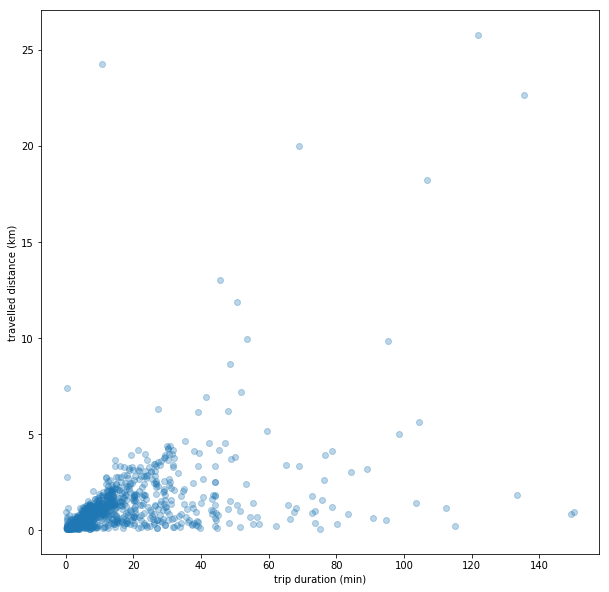


--- CATEGORY: 2


count      731.000000
mean       358.024105
std       2742.087814
min         11.447000
25%         38.839000
50%         57.643000
75%         66.313500
max      51839.264000
Name: total_duration, dtype: float64

count    7.310000e+02
mean     1.226669e+01
std      1.685991e+01
min      3.536620e-10
25%      1.936460e+00
50%      5.121611e+00
75%      1.515303e+01
max      1.598219e+02
Name: total_distance, dtype: float64

count    7.310000e+02
mean     8.263820e-01
std      1.417694e+00
min      6.443281e-13
25%      1.077632e-01
50%      2.891202e-01
75%      8.062049e-01
max      1.157095e+01
Name: avg_speed, dtype: float64

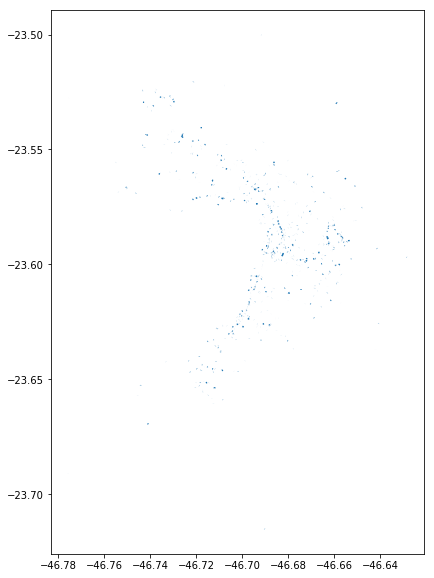

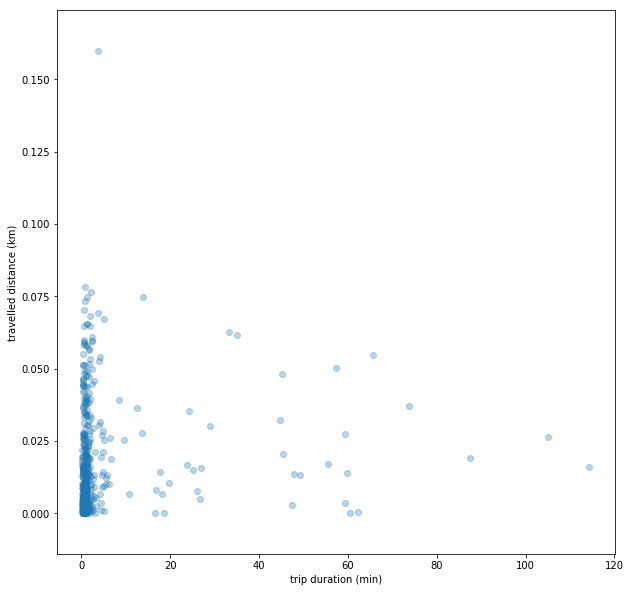


--- CATEGORY: 3


count      119.000000
mean      1922.285353
std       7638.084391
min         60.554000
25%        460.473000
50%        790.075000
75%       1616.027500
max      83307.310000
Name: total_duration, dtype: float64

count      119.000000
mean      1402.812432
std       1493.358720
min        104.161872
25%        574.281611
50%       1054.090049
75%       1561.398797
max      11805.728825
Name: total_distance, dtype: float64

count    119.000000
mean       5.809137
std        3.458384
min        0.064578
25%        3.219879
50%        5.764254
75%        8.161849
max       14.961642
Name: avg_speed, dtype: float64

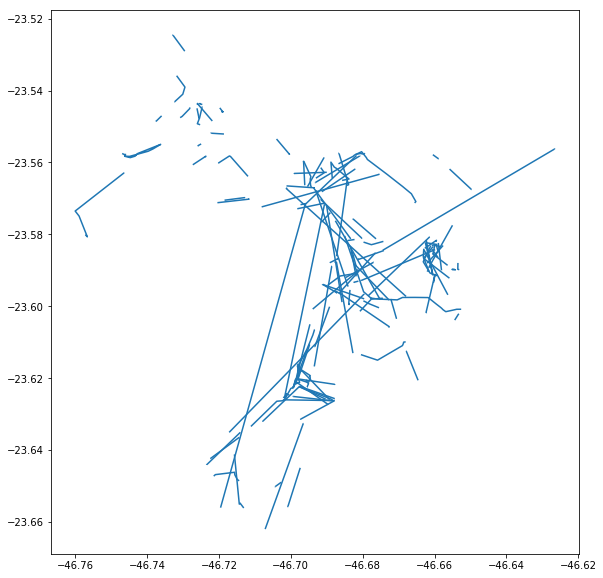

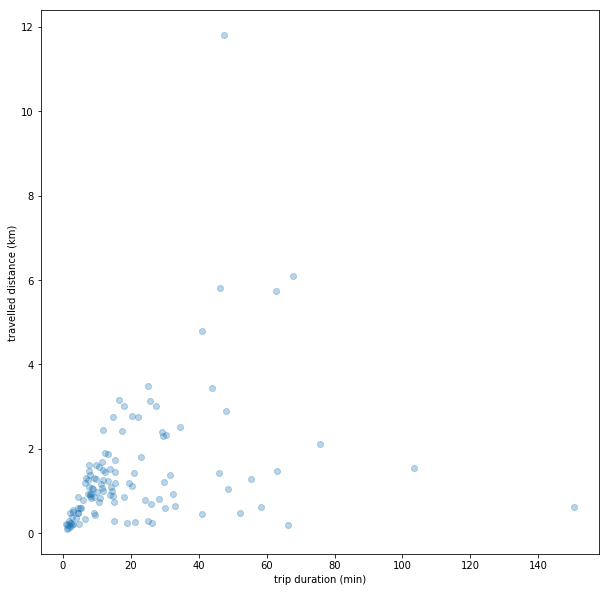


--- CATEGORY: 4


count     5536.000000
mean        78.776281
std       1135.529911
min         11.239000
25%         31.540000
50%         41.919000
75%         50.032500
max      83440.232000
Name: total_duration, dtype: float64

count    5536.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: total_distance, dtype: float64

count    5536.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: avg_speed, dtype: float64

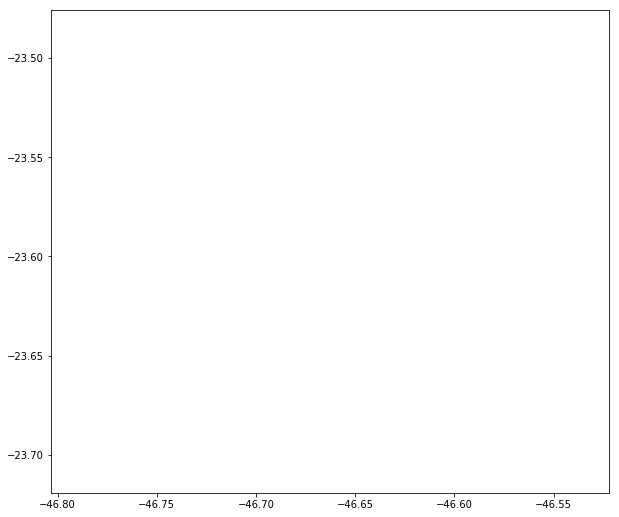

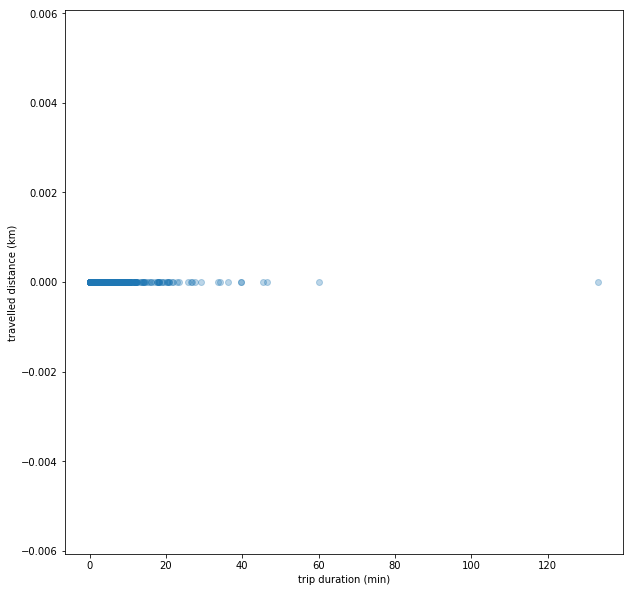


--- CATEGORY: 5


count      233.000000
mean      1198.759395
std       1586.220105
min         74.682000
25%        301.390000
50%        524.059000
75%       1334.678000
max      11363.258000
Name: total_duration, dtype: float64

count      233.000000
mean      1569.800277
std       5187.249674
min         87.386850
25%        399.251644
50%        737.602153
75%       1314.438274
max      71203.045847
Name: total_distance, dtype: float64

count    233.000000
mean       6.533176
std       12.753685
min        0.088469
25%        2.466386
50%        6.228638
75%        8.232204
max      192.246253
Name: avg_speed, dtype: float64

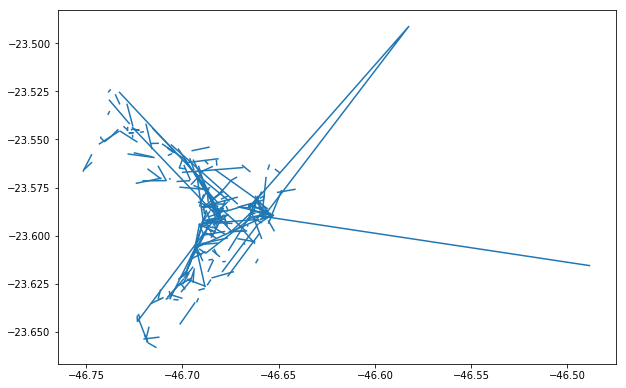

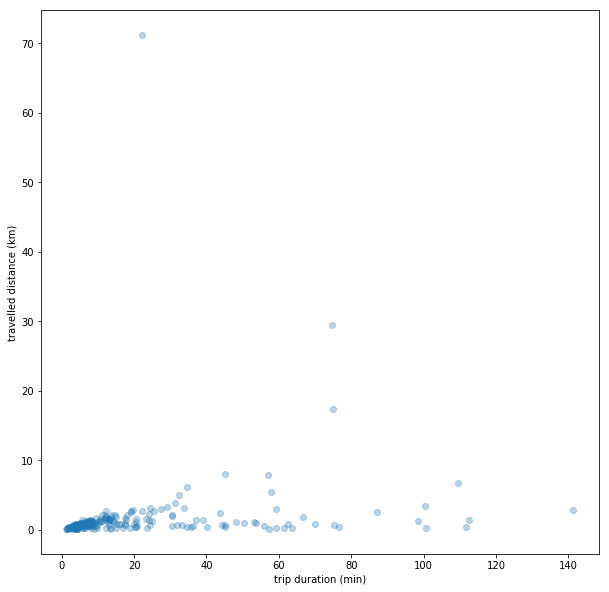


--- CATEGORY: 6


count     179.000000
mean      179.693804
std       545.513103
min        30.008000
25%        58.633500
50%        60.667000
75%        64.463000
max      4948.062000
Name: total_duration, dtype: float64

count    1.790000e+02
mean     7.587077e+00
std      1.248113e+01
min      7.385024e-10
25%      1.505638e+00
50%      3.508367e+00
75%      7.571379e+00
max      8.191423e+01
Name: total_distance, dtype: float64

count    1.790000e+02
mean     2.995544e-01
std      3.915051e-01
min      5.809554e-12
25%      8.029185e-02
50%      1.886377e-01
75%      4.007638e-01
max      3.359378e+00
Name: avg_speed, dtype: float64

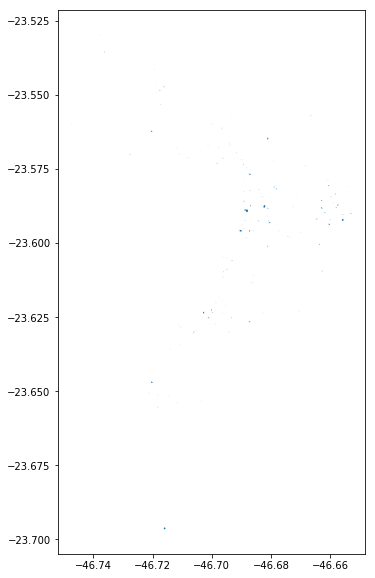

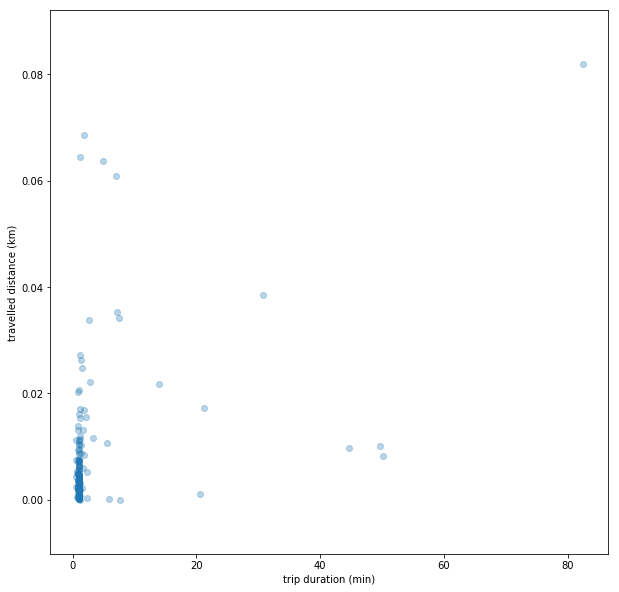


--- CATEGORY: 7


count      36.000000
mean     1337.307278
std      1584.893975
min        81.836000
25%       289.710250
50%       622.959000
75%      1625.400000
max      7033.199000
Name: total_duration, dtype: float64

count      36.000000
mean     1108.140811
std      1248.626438
min       100.778176
25%       370.791315
50%       835.228472
75%      1287.733750
max      7286.452414
Name: total_distance, dtype: float64

count    36.000000
mean      4.894019
std       3.437358
min       0.422842
25%       2.080834
50%       4.391516
75%       7.016793
max      13.578317
Name: avg_speed, dtype: float64

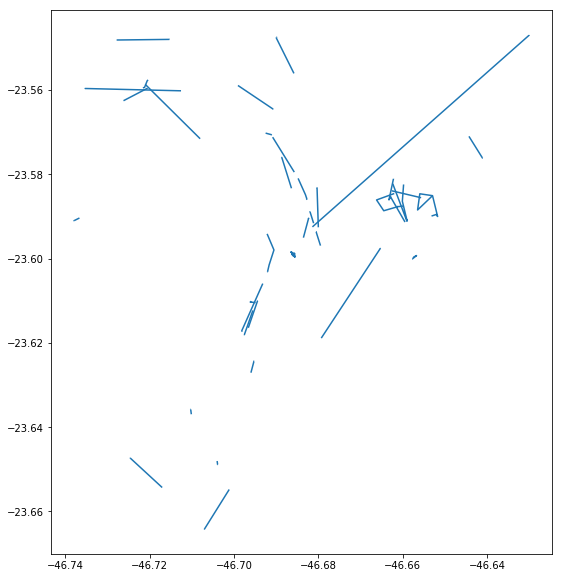

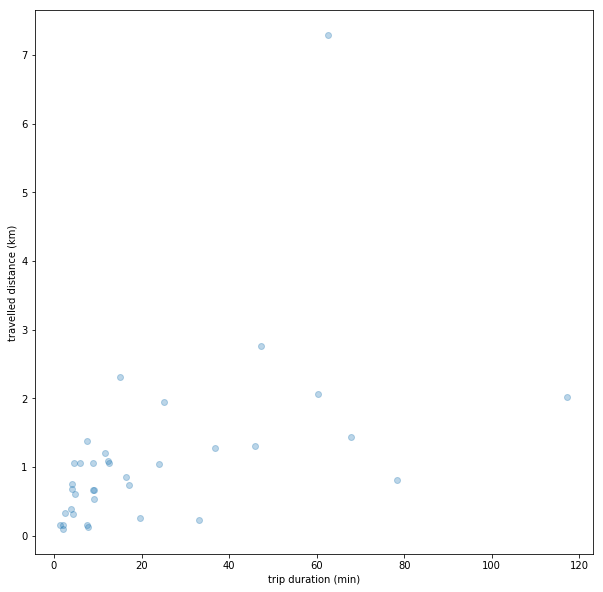


--- CATEGORY: 8


count     312.000000
mean       91.346535
std       168.770820
min         0.392000
25%         9.416250
50%        24.820000
75%        81.107750
max      1406.634000
Name: total_duration, dtype: float64

count      312.000000
mean      2201.924080
std       6099.941054
min         76.224833
25%        168.823324
50%        402.231992
75%       1858.575980
max      79940.283744
Name: total_distance, dtype: float64

count     312.000000
mean      234.615842
std       726.047557
min         3.944209
25%        26.244070
50%        66.097160
75%       167.327149
max      7851.252285
Name: avg_speed, dtype: float64

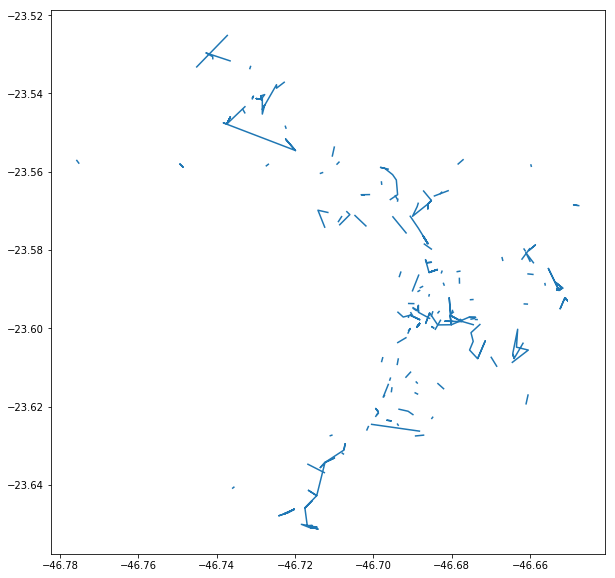

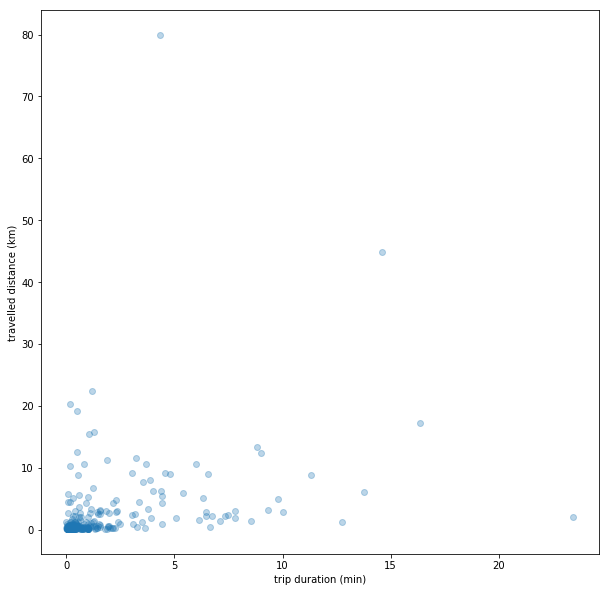


--- CATEGORY: 9


count      114.000000
mean      1062.814763
std       2109.314156
min         22.823000
25%        214.423750
50%        400.447000
75%       1093.689250
max      17544.762000
Name: total_duration, dtype: float64

count      114.000000
mean      3086.323256
std       7528.865876
min        220.678371
25%        845.616626
50%       1302.190574
75%       2161.363131
max      69944.856851
Name: total_distance, dtype: float64

count     114.000000
mean       66.543210
std       340.129067
min         0.218742
25%         7.409228
50%        11.283596
75%        18.238732
max      3316.357903
Name: avg_speed, dtype: float64

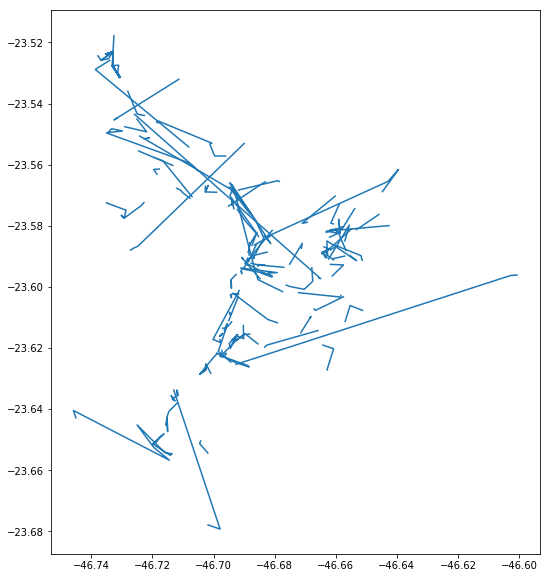

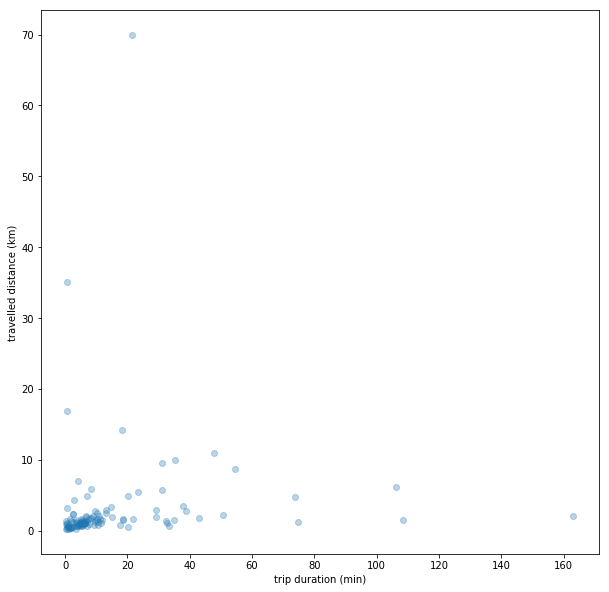


--- CATEGORY: 10


count      35.000000
mean      307.211714
std       554.316064
min        22.342000
25%        35.671500
50%        72.347000
75%       281.978500
max      2223.081000
Name: total_duration, dtype: float64

count       35.000000
mean      2005.532571
std       4562.382221
min         90.789594
25%        144.677167
50%        265.264833
75%       1777.003264
max      25695.164330
Name: total_distance, dtype: float64

count     35.000000
mean      30.611051
std       31.653032
min        0.198760
25%        8.906052
50%       22.665924
75%       34.812568
max      129.463197
Name: avg_speed, dtype: float64

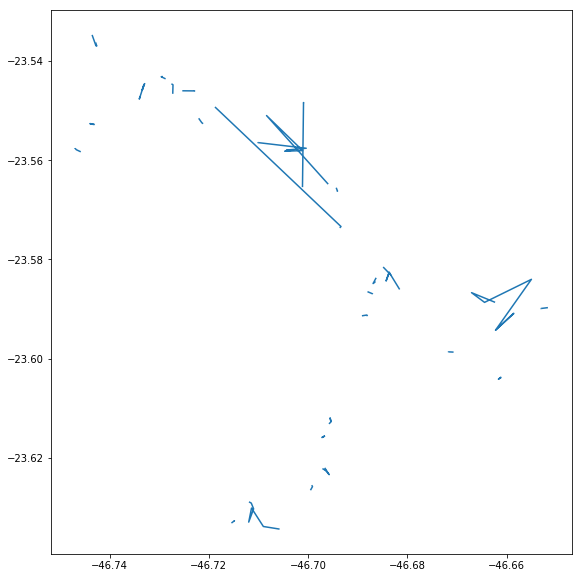

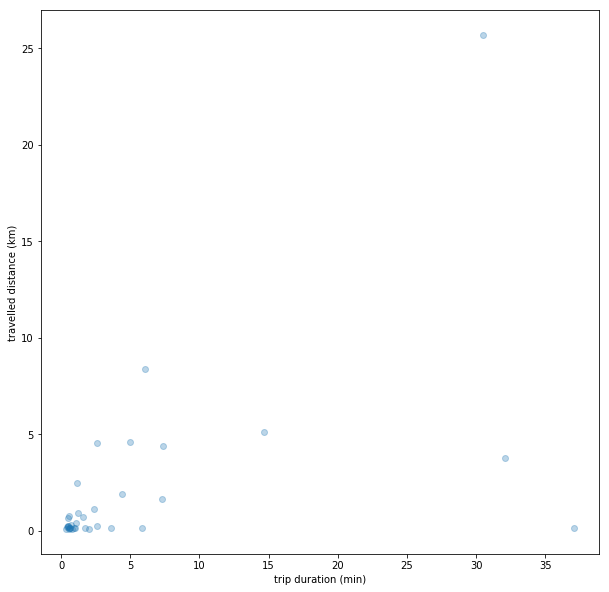


--- CATEGORY: 11


count      19.000000
mean     1287.743526
std      1916.487327
min       107.012000
25%       329.995500
50%       586.350000
75%      1484.806500
max      7038.350000
Name: total_duration, dtype: float64

count       19.000000
mean      3830.546755
std       7597.265754
min        518.178191
25%       1281.358817
50%       1951.407786
75%       3338.984878
max      34851.926629
Name: total_distance, dtype: float64

count     19.000000
mean      25.839169
std       47.318157
min        1.175017
25%        6.691617
50%       10.484203
75%       20.398944
max      207.689922
Name: avg_speed, dtype: float64

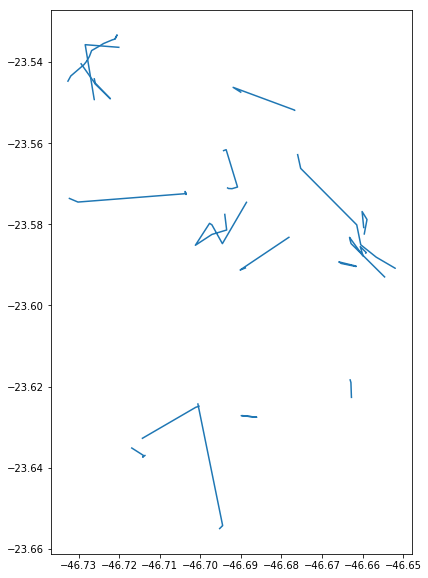

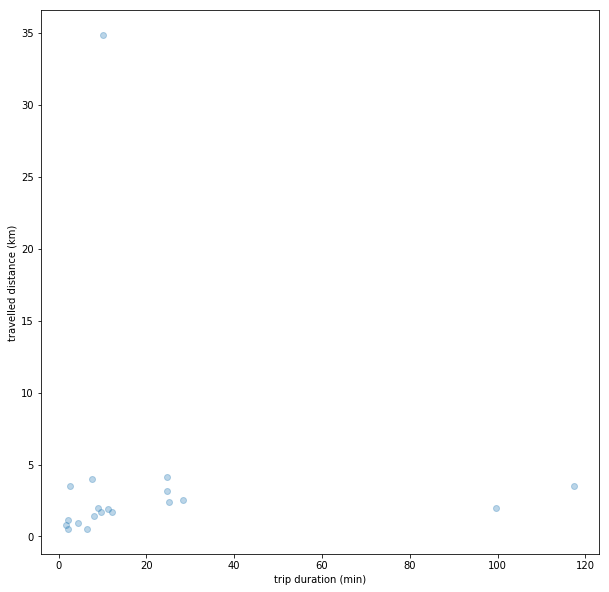


--- CATEGORY: 12


count      59.000000
mean      335.699966
std       466.459041
min        23.962000
25%        52.947000
50%       130.019000
75%       471.260500
max      2274.882000
Name: total_duration, dtype: float64

count       59.000000
mean      3456.348363
std       6208.919419
min         76.969172
25%        255.692955
50%        627.846541
75%       3344.975386
max      34211.574658
Name: total_distance, dtype: float64

count      59.000000
mean       94.603362
std       274.701063
min         0.362599
25%         7.945940
50%        19.803262
75%        40.880643
max      1754.808928
Name: avg_speed, dtype: float64

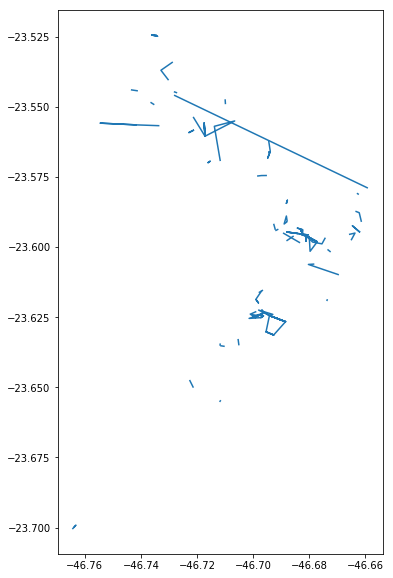

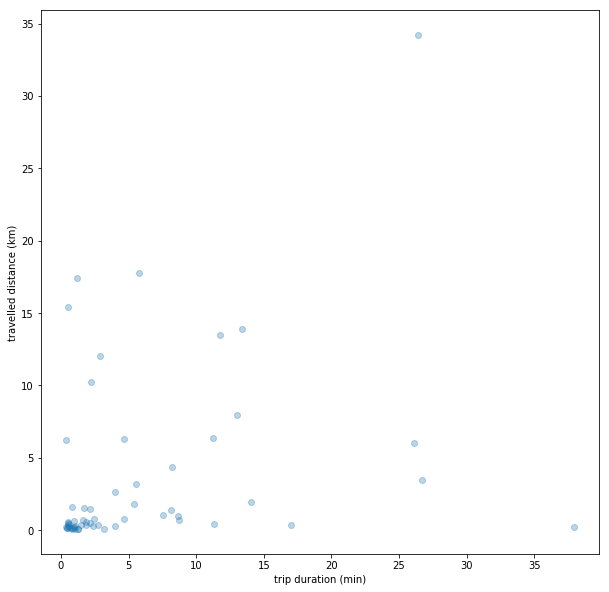


--- CATEGORY: 13


count      66.000000
mean      877.986924
std      1001.422096
min       107.979000
25%       306.103250
50%       535.239500
75%       888.177500
max      5779.545000
Name: total_duration, dtype: float64

count       66.000000
mean      8249.920827
std      14315.806843
min        232.408950
25%       2038.521409
50%       4196.385755
75%       8133.997317
max      76911.358142
Name: total_distance, dtype: float64

count     66.000000
mean      45.952689
std       63.793120
min        0.967843
25%       10.633695
50%       24.469680
75%       57.474984
max      421.687063
Name: avg_speed, dtype: float64

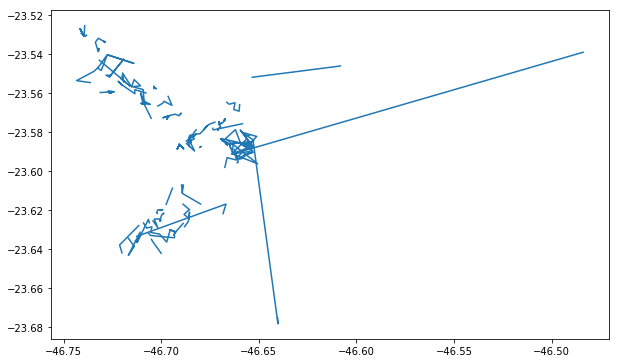

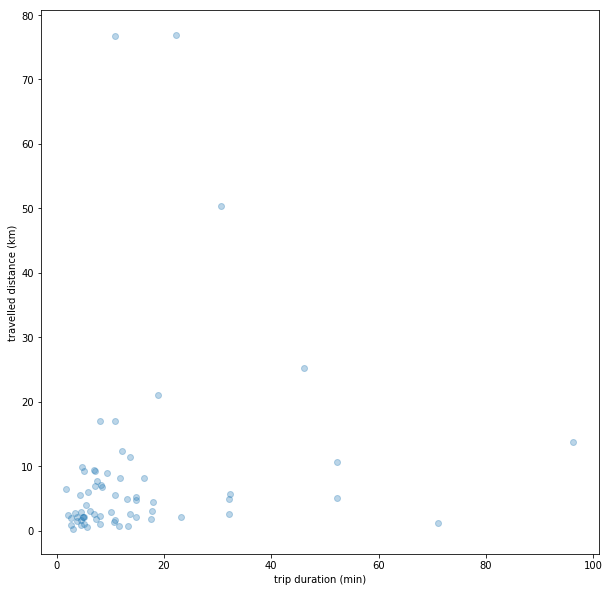


--- CATEGORY: 14


count       7.000000
mean      458.812857
std       496.837513
min        61.559000
25%       191.690500
50%       365.256000
75%       437.891500
max      1525.711000
Name: total_duration, dtype: float64

count        7.000000
mean      4036.675605
std       8612.371861
min        104.054548
25%        409.345837
50%        781.061239
75%       1525.557433
max      23501.806911
Name: total_distance, dtype: float64

count     7.000000
mean     15.628630
std      18.332000
min       5.145272
25%       5.943878
50%       8.175612
75%      14.368975
max      55.453821
Name: avg_speed, dtype: float64

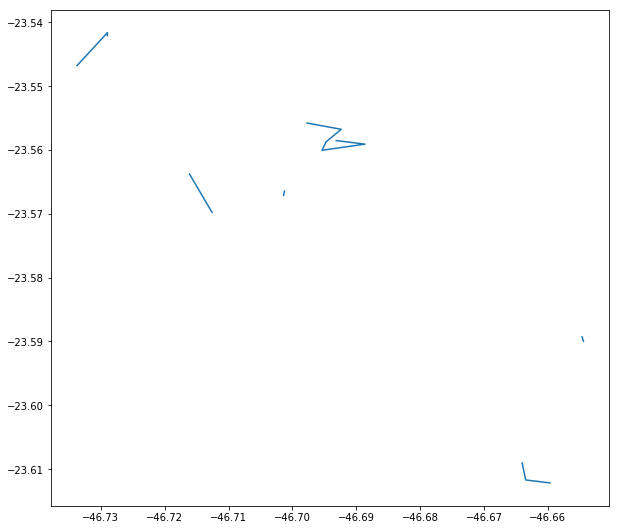

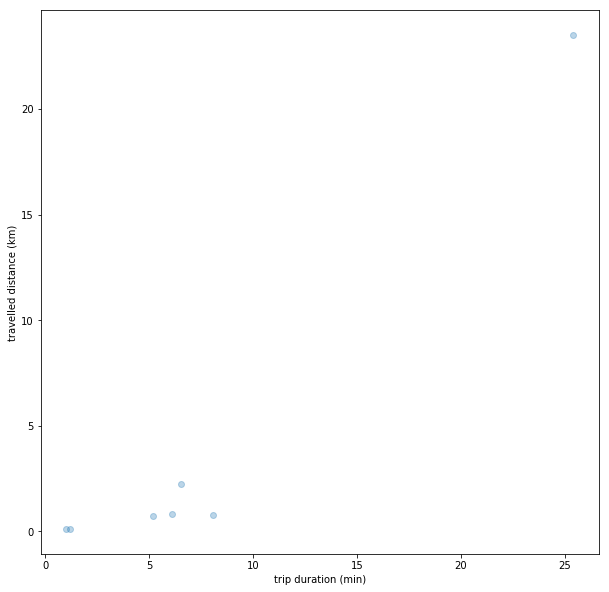


--- CATEGORY: 15


count      16.000000
mean     1828.439438
std      1632.584759
min       105.957000
25%       552.706000
50%      1376.807000
75%      2710.165500
max      5295.798000
Name: total_duration, dtype: float64

count        16.000000
mean      27877.359759
std       45324.311453
min         446.228506
25%        2112.975372
50%        6646.633895
75%       21109.767270
max      143420.609710
Name: total_distance, dtype: float64

count     16.000000
mean      44.550364
std       48.446093
min        3.928184
25%       13.470025
50%       22.649351
75%       51.198936
max      155.972201
Name: avg_speed, dtype: float64

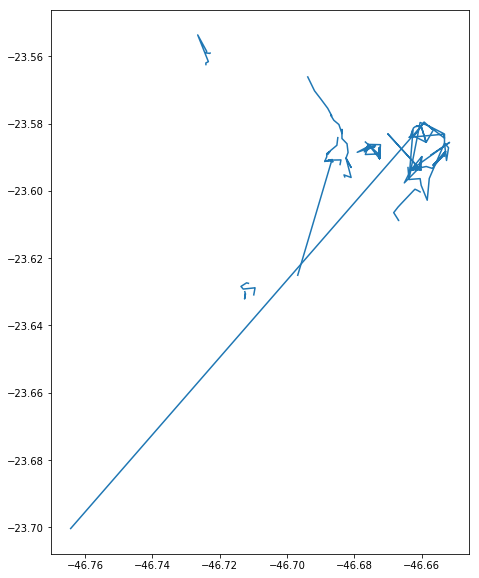

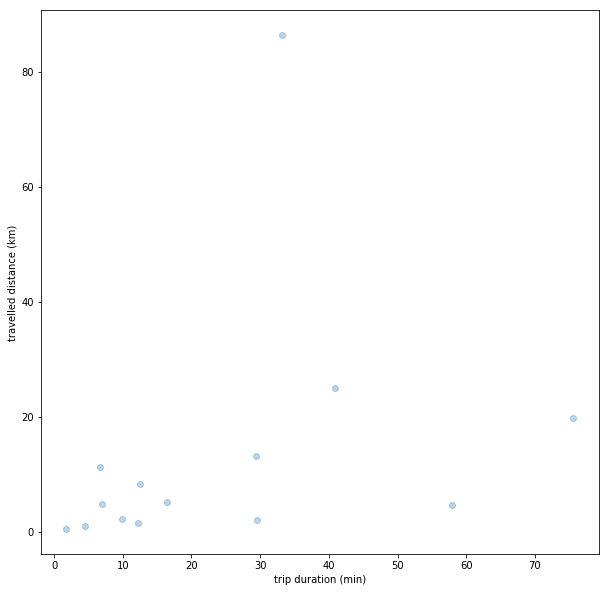


--- CATEGORY: 16


count    57901.000000
mean       470.364674
std        634.725848
min          0.055000
25%         69.517000
50%        304.844000
75%        600.031000
max      20461.389000
Name: total_duration, dtype: float64

count    5.790100e+04
mean     1.058734e+03
std      1.417457e+03
min      3.536620e-10
25%      4.688855e+01
50%      6.939835e+02
75%      1.445812e+03
max      2.490923e+04
Name: total_distance, dtype: float64

count    5.790100e+04
mean     7.005418e+00
std      6.825654e+00
min      1.962654e-12
25%      2.789504e+00
50%      7.575046e+00
75%      1.014009e+01
max      6.903255e+02
Name: avg_speed, dtype: float64

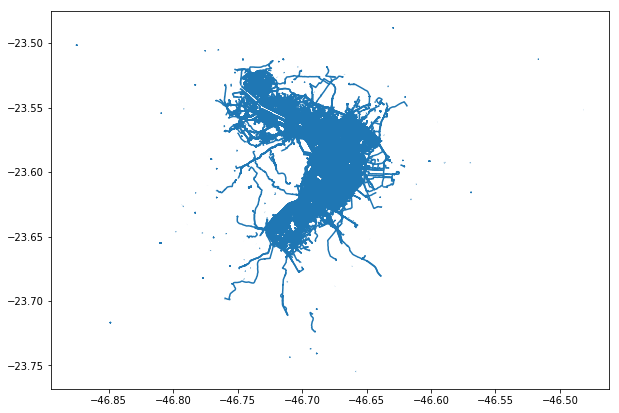

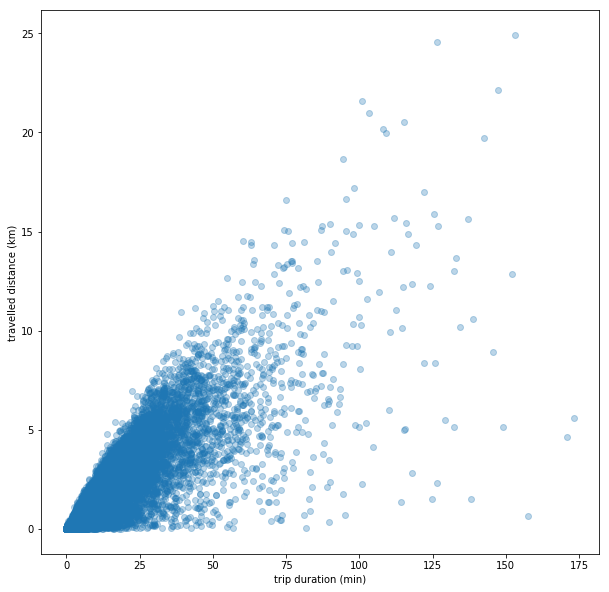


--- CATEGORY: 17


count    7.729000e+03
mean     1.843054e+03
std      1.768021e+04
min      1.391400e+01
25%      3.839690e+02
50%      7.190890e+02
75%      1.560774e+03
max      1.176017e+06
Name: total_duration, dtype: float64

count     7729.000000
mean      1718.274535
std       2041.609147
min         78.934983
25%        624.798463
50%       1114.641035
75%       2064.014193
max      30003.571738
Name: total_distance, dtype: float64

count    7729.000000
mean        6.582250
std         5.255158
min         0.004073
25%         3.642486
50%         6.521756
75%         8.936841
max       304.498112
Name: avg_speed, dtype: float64

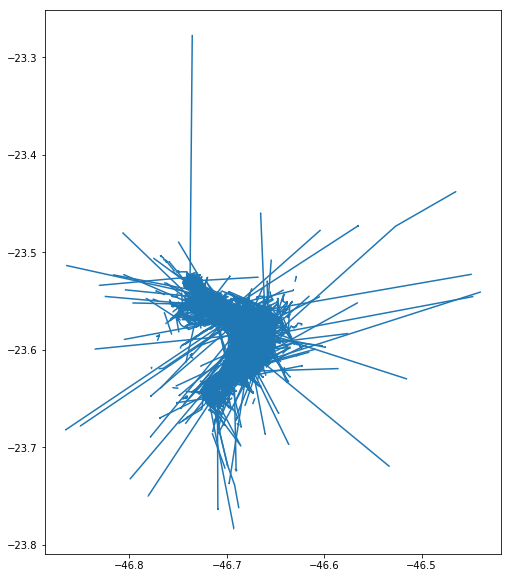

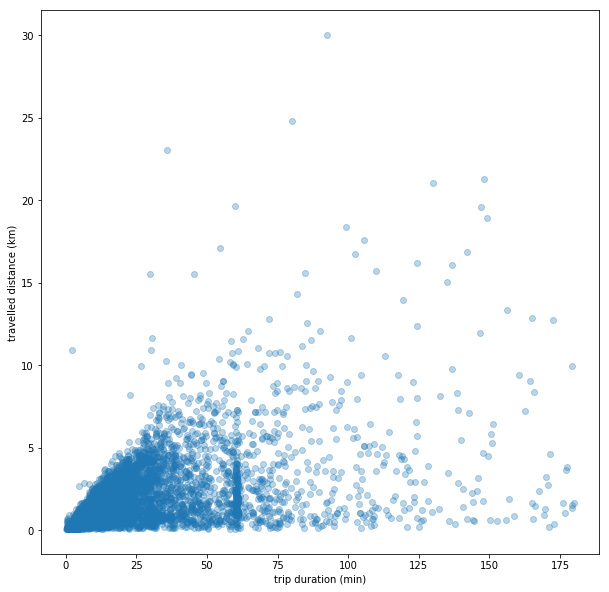


--- CATEGORY: 18


count     39628.000000
mean        937.715114
std        2172.397029
min          12.970000
25%         334.516250
50%         585.039500
75%        1033.666500
max      173394.806000
Name: total_duration, dtype: float64

count    39628.000000
mean      1740.584882
std       1796.242424
min          0.000049
25%        641.207295
50%       1244.893998
75%       2215.823000
max      31632.855757
Name: total_distance, dtype: float64

count    39628.000000
mean         7.479227
std          3.470705
min          0.000001
25%          5.298120
50%          7.994303
75%          9.951063
max         23.006982
Name: avg_speed, dtype: float64

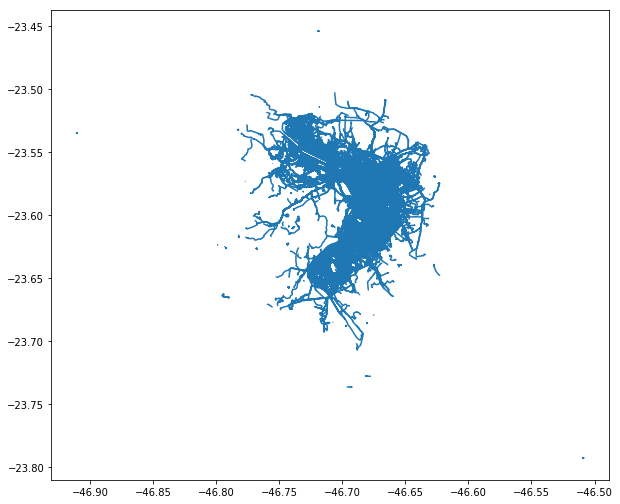

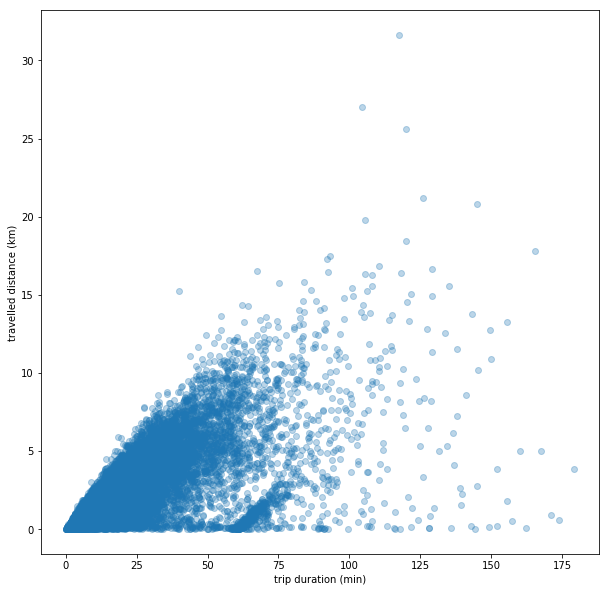


--- CATEGORY: 19


count    1.018600e+04
mean     2.009032e+03
std      1.493350e+04
min      4.636600e+01
25%      5.311763e+02
50%      9.292255e+02
75%      1.969439e+03
max      1.264654e+06
Name: total_duration, dtype: float64

count    10186.000000
mean      2482.887072
std       2462.360505
min         79.085902
25%       1039.653853
50%       1741.507191
75%       3096.383491
max      51787.832849
Name: total_distance, dtype: float64

count    10186.000000
mean         7.400691
std          4.743289
min          0.003085
25%          4.800221
50%          7.652452
75%          9.826894
max        306.202221
Name: avg_speed, dtype: float64

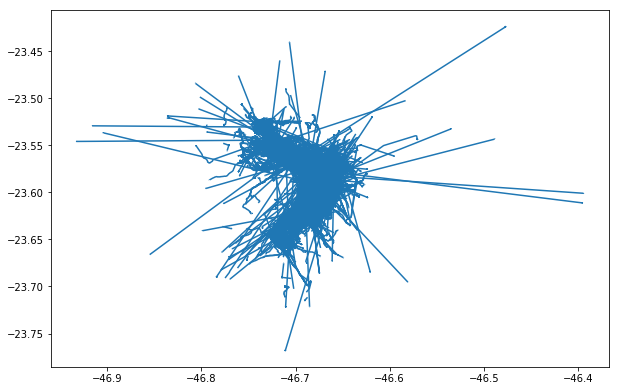

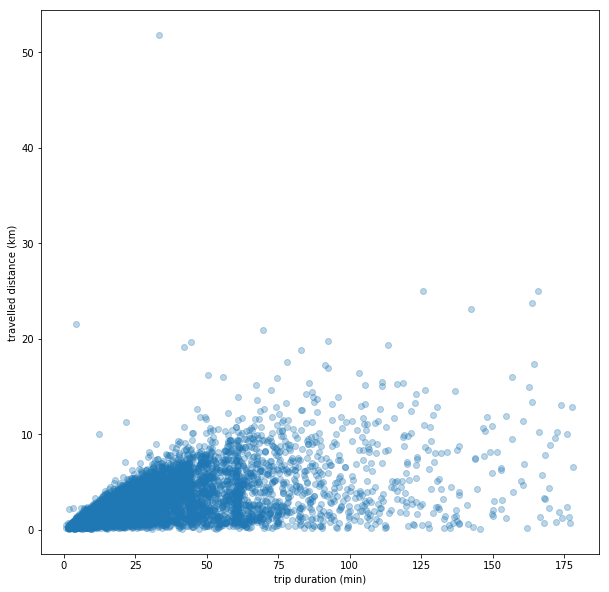


--- CATEGORY: 20


count     7535.000000
mean       675.545606
std       1889.016819
min         13.351000
25%        100.346000
50%        350.807000
75%        706.667000
max      75978.038000
Name: total_duration, dtype: float64

count    7.535000e+03
mean     1.081694e+03
std      1.477314e+03
min      3.536620e-10
25%      3.651867e+01
50%      6.800564e+02
75%      1.469983e+03
max      1.789707e+04
Name: total_distance, dtype: float64

count    7.535000e+03
mean     5.665498e+00
std      4.172636e+00
min      6.880833e-13
25%      1.162970e+00
50%      6.205349e+00
75%      9.027408e+00
max      1.924100e+01
Name: avg_speed, dtype: float64

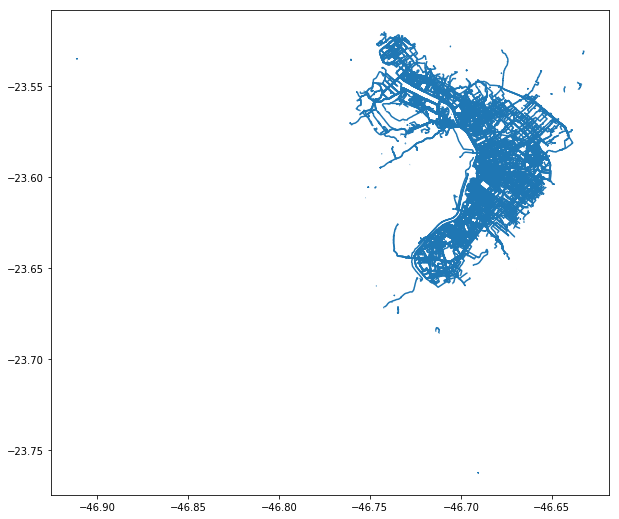

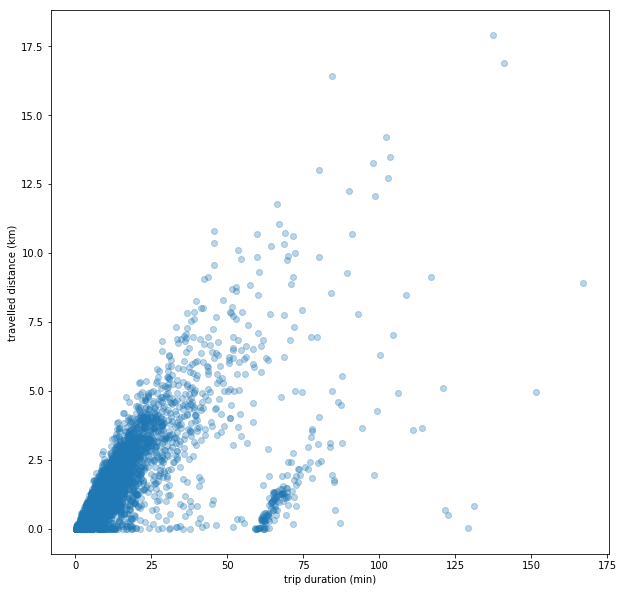


--- CATEGORY: 21


count      1619.000000
mean       1756.898421
std       23457.860974
min          46.492000
25%         370.162000
50%         665.482000
75%        1312.288000
max      942663.408000
Name: total_duration, dtype: float64

count      1619.000000
mean       1595.028833
std        3049.624508
min          89.611679
25%         559.845846
50%        1008.673732
75%        1853.568178
max      101133.872772
Name: total_distance, dtype: float64

count    1619.000000
mean        6.383763
std         5.111211
min         0.003468
25%         3.781913
50%         6.182131
75%         8.327058
max       130.905584
Name: avg_speed, dtype: float64

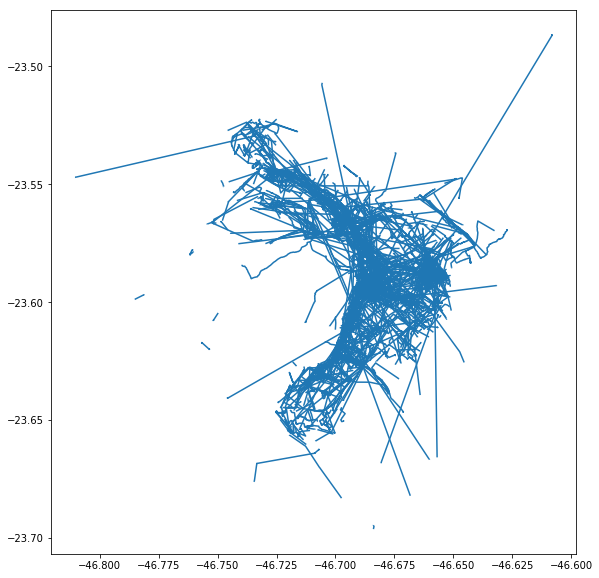

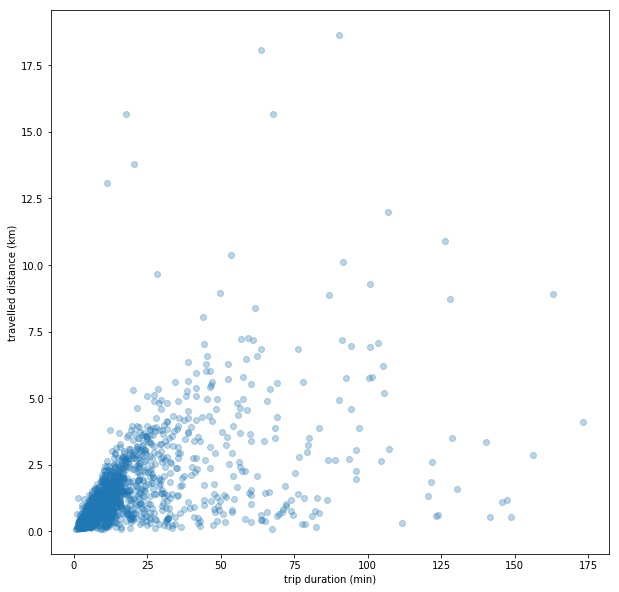


--- CATEGORY: 22


count    7.949000e+03
mean     1.937389e+03
std      2.097175e+04
min      3.026800e+01
25%      5.513040e+02
50%      1.039822e+03
75%      2.039279e+03
max      1.809787e+06
Name: total_duration, dtype: float64

count     7949.000000
mean      2280.239119
std       2358.675612
min          0.008763
25%        681.250701
50%       1556.282267
75%       3165.822413
max      22281.519198
Name: total_distance, dtype: float64

count    7949.000000
mean        5.759971
std         3.385153
min         0.000042
25%         2.937594
50%         5.934413
75%         8.364425
max        17.316649
Name: avg_speed, dtype: float64

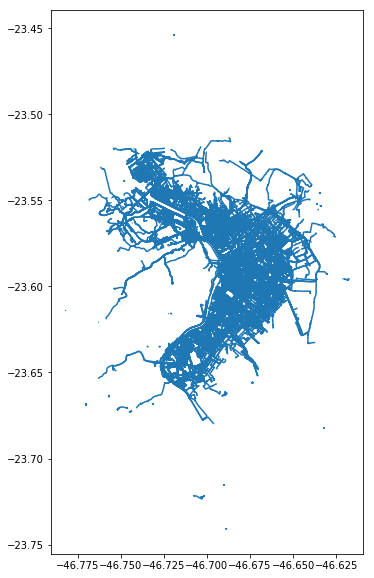

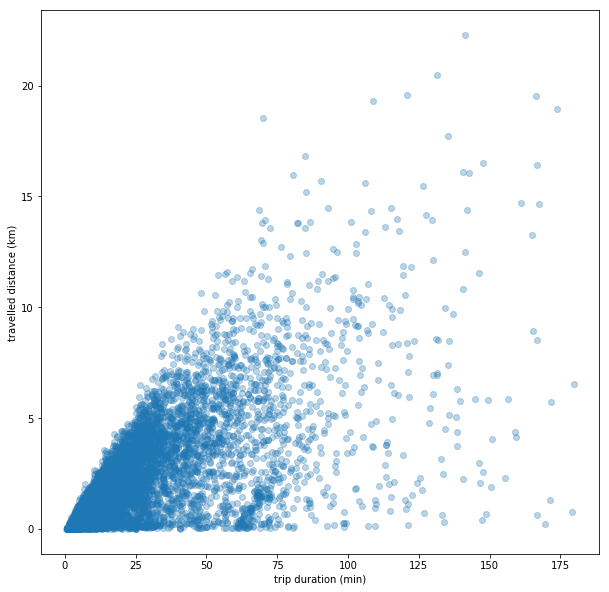


--- CATEGORY: 23


count    4.334000e+03
mean     3.136134e+03
std      2.230874e+04
min      7.493000e+01
25%      8.168062e+02
50%      1.662884e+03
75%      3.348638e+03
max      1.310226e+06
Name: total_duration, dtype: float64

count     4334.000000
mean      3259.179298
std       3417.853183
min        100.570794
25%       1245.299293
50%       2259.302264
75%       4226.032035
max      88871.293536
Name: total_distance, dtype: float64

count    4334.000000
mean        6.152424
std         5.120669
min         0.002271
25%         3.428428
50%         5.938685
75%         8.338678
max       177.858585
Name: avg_speed, dtype: float64

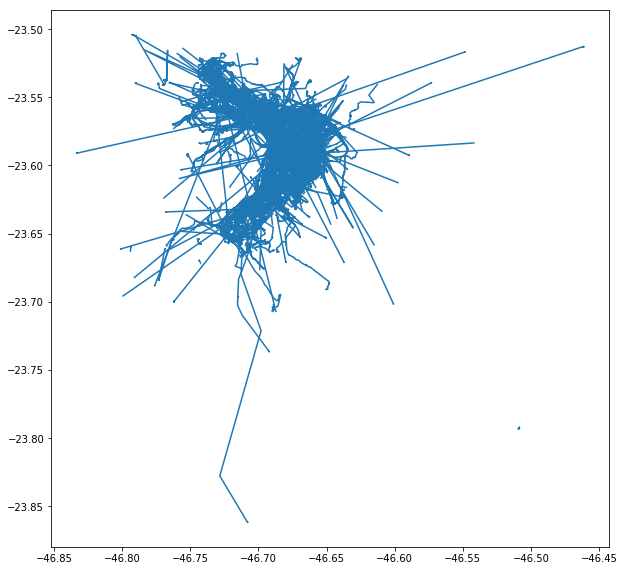

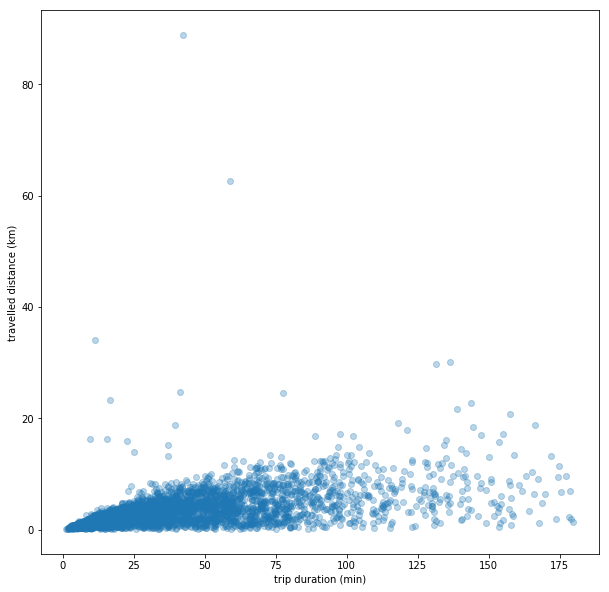


--- CATEGORY: 24


count    19231.000000
mean       684.348268
std        745.369519
min          2.498000
25%        288.530000
50%        475.731000
75%        809.748000
max      19872.361000
Name: total_duration, dtype: float64

count     19231.000000
mean       2981.986079
std        9180.405197
min          77.223882
25%         987.523873
50%        1647.769300
75%        2860.532334
max      568300.280416
Name: total_distance, dtype: float64

count    19231.000000
mean        18.795198
std         74.123927
min          0.511507
25%          9.886472
50%         12.165801
75%         15.512155
max       5884.362794
Name: avg_speed, dtype: float64

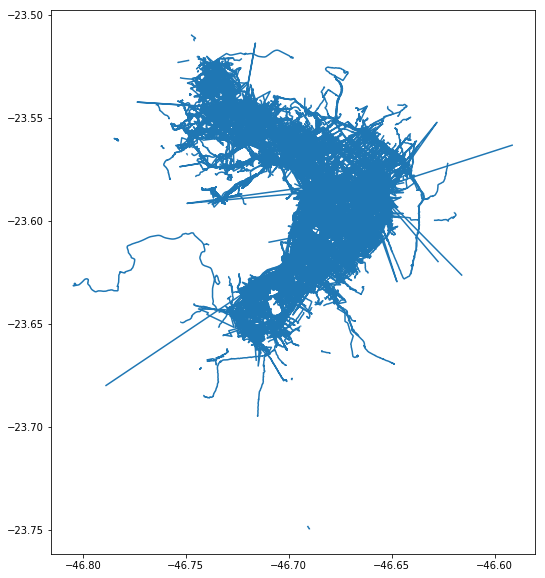

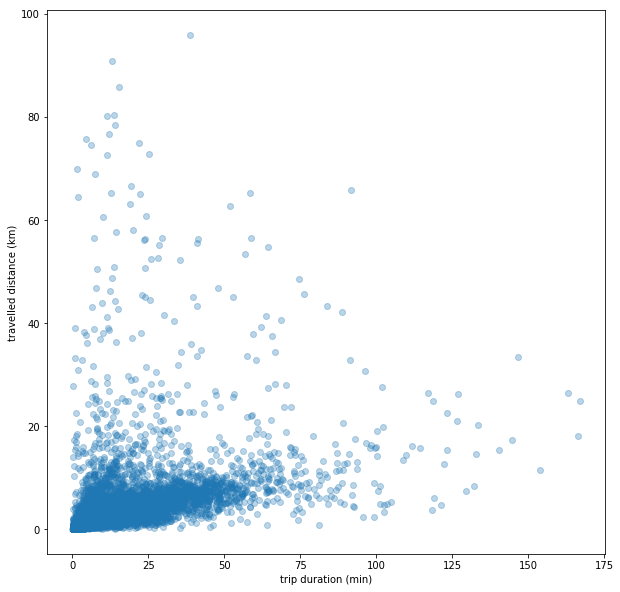


--- CATEGORY: 25


count      2884.000000
mean       1955.035780
std        9918.477688
min          28.329000
25%         428.288000
50%         800.649000
75%        1639.072000
max      329192.783000
Name: total_duration, dtype: float64

count      2884.000000
mean       5953.547095
std       23712.943559
min         181.032281
25%        1315.571955
50%        2338.736978
75%        4428.890847
max      746991.626156
Name: total_distance, dtype: float64

count    2884.000000
mean       19.510705
std        60.137496
min         0.033776
25%         7.475378
50%        11.182024
75%        15.693020
max      2075.709857
Name: avg_speed, dtype: float64

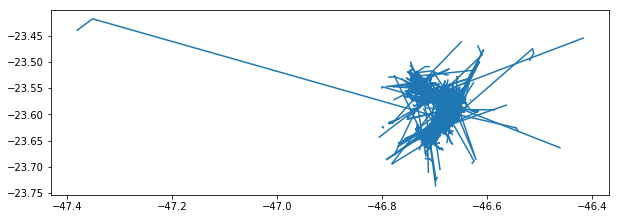

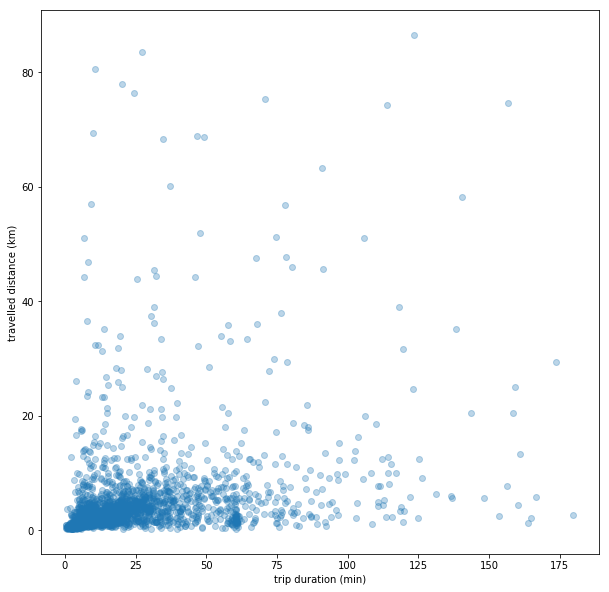


--- CATEGORY: 26


count     13939.000000
mean       1170.406841
std        7472.044252
min          23.970000
25%         410.932000
50%         698.610000
75%        1283.553500
max      864893.836000
Name: total_duration, dtype: float64

count    1.393900e+04
mean     3.766948e+03
std      2.331816e+04
min      8.639070e+01
25%      1.247357e+03
50%      2.097326e+03
75%      3.745024e+03
max      2.258983e+06
Name: total_distance, dtype: float64

count    13939.000000
mean        13.125525
std         30.939610
min          0.013378
25%          8.712061
50%         10.865071
75%         13.185108
max       2079.578321
Name: avg_speed, dtype: float64

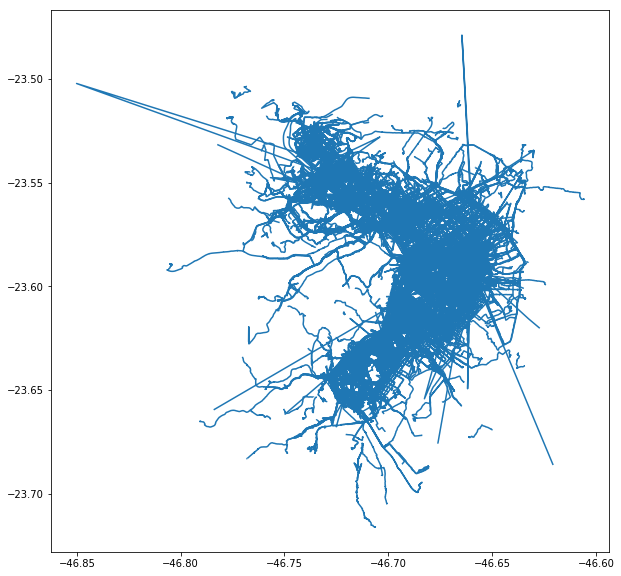

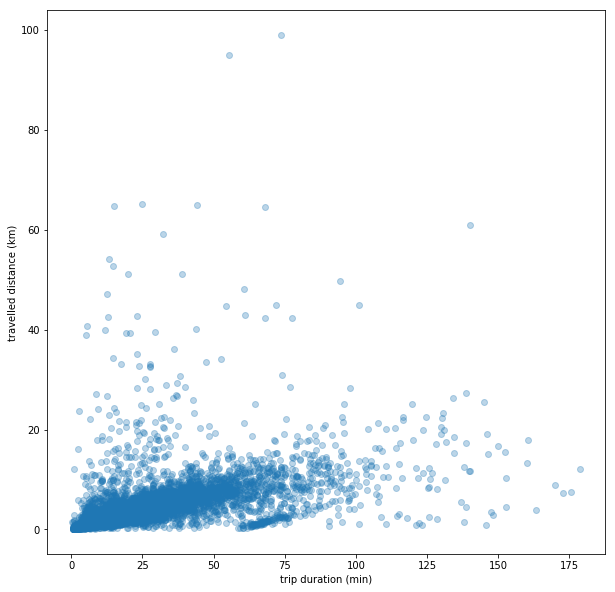


--- CATEGORY: 27


count      8237.000000
mean       2109.408377
std       11137.133989
min          69.805000
25%         597.035000
50%        1051.841000
75%        2118.831000
max      691868.161000
Name: total_duration, dtype: float64

count      8237.000000
mean       5349.425249
std       13699.775315
min         233.247150
25%        1817.871438
50%        3052.893195
75%        5488.516427
max      573905.282388
Name: total_distance, dtype: float64

count    8237.000000
mean       13.432939
std        25.679753
min         0.011522
25%         8.199271
50%        10.951594
75%        13.695087
max       863.262104
Name: avg_speed, dtype: float64

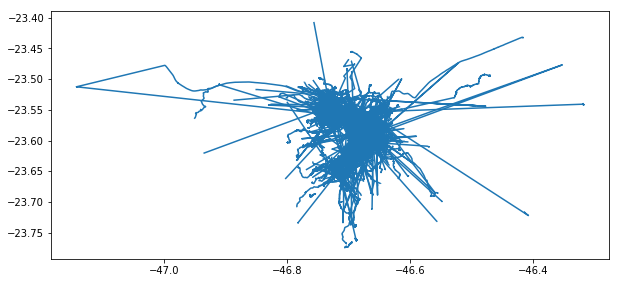

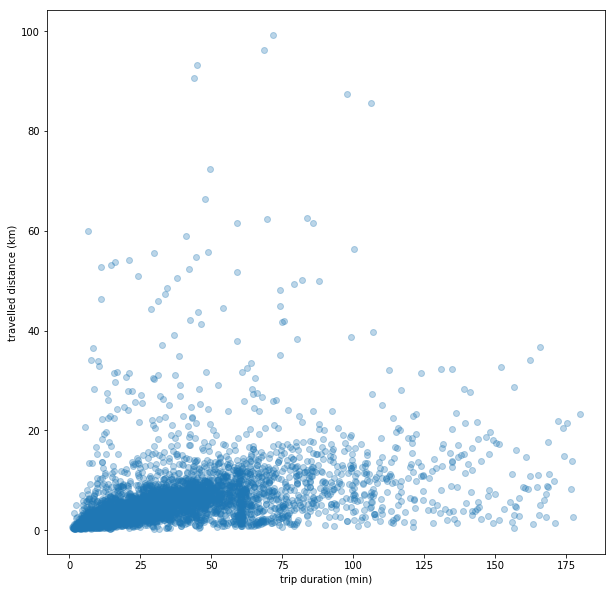


--- CATEGORY: 28


count     3365.000000
mean       864.649852
std       1073.615989
min         25.260000
25%        332.666000
50%        566.092000
75%        974.246000
max      33339.399000
Name: total_duration, dtype: float64

count      3365.000000
mean       6199.813871
std       25517.825380
min          89.385835
25%        1097.948101
50%        1967.950852
75%        3770.633813
max      540808.801757
Name: total_distance, dtype: float64

count    3365.000000
mean       21.965272
std        58.879148
min         0.092887
25%         9.382987
50%        12.013849
75%        16.287038
max      2069.020872
Name: avg_speed, dtype: float64

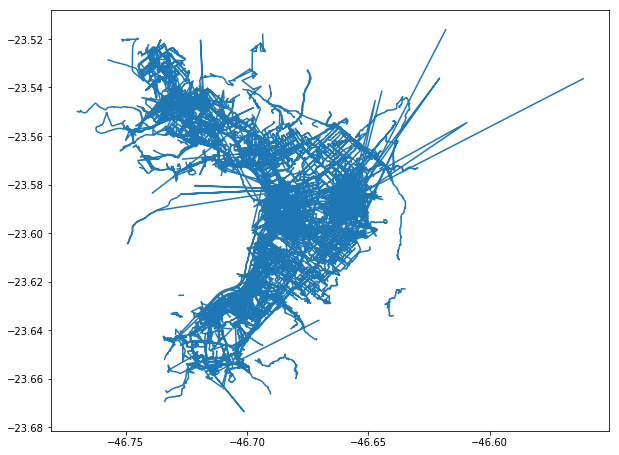

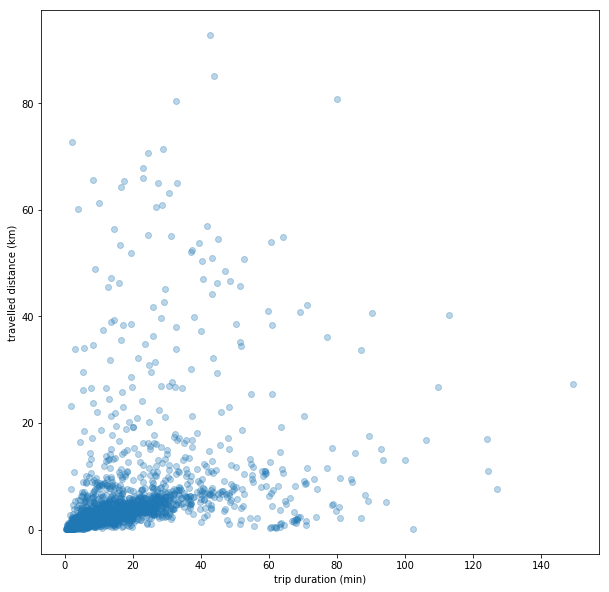


--- CATEGORY: 29


count     1425.000000
mean      1567.994643
std       2245.956430
min         68.339000
25%        504.646000
50%        901.929000
75%       1847.871000
max      38169.921000
Name: total_duration, dtype: float64

count      1425.000000
mean      16110.740362
std       40638.726954
min         226.786510
25%        1740.959196
50%        3954.112651
75%       11459.086975
max      575996.387137
Name: total_distance, dtype: float64

count    1425.000000
mean       38.470443
std        71.779834
min         0.362853
25%         8.965423
50%        14.526520
75%        36.602364
max       829.536040
Name: avg_speed, dtype: float64

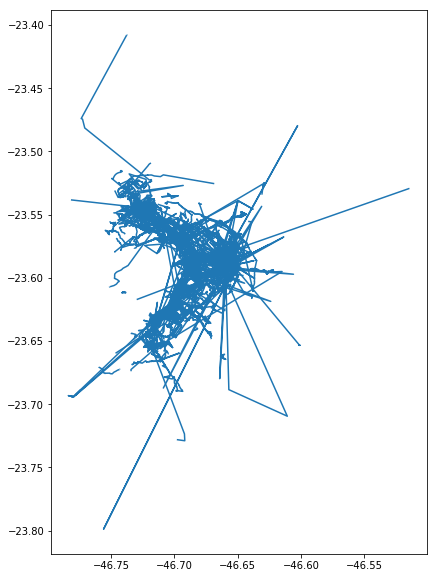

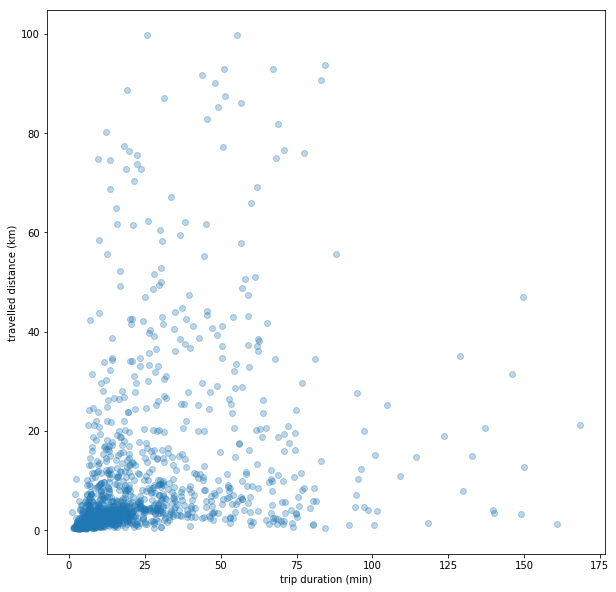


--- CATEGORY: 30


count      4266.000000
mean       1982.314630
std        5682.768619
min          40.662000
25%         600.293750
50%        1102.072000
75%        2218.591750
max      298545.617000
Name: total_duration, dtype: float64

count      4266.000000
mean       6436.048431
std       23132.150192
min          92.012925
25%        1543.744470
50%        2849.795057
75%        5308.534066
max      628479.394548
Name: total_distance, dtype: float64

count    4266.000000
mean       15.450528
std        86.499705
min         0.049971
25%         6.627026
50%         9.474834
75%        12.508900
max      4998.433262
Name: avg_speed, dtype: float64

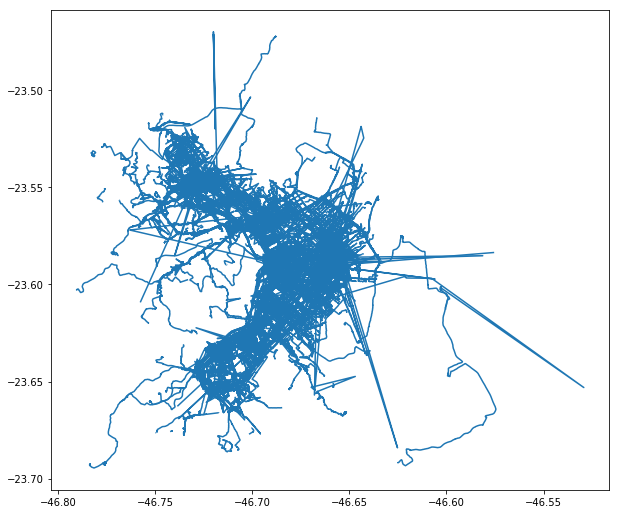

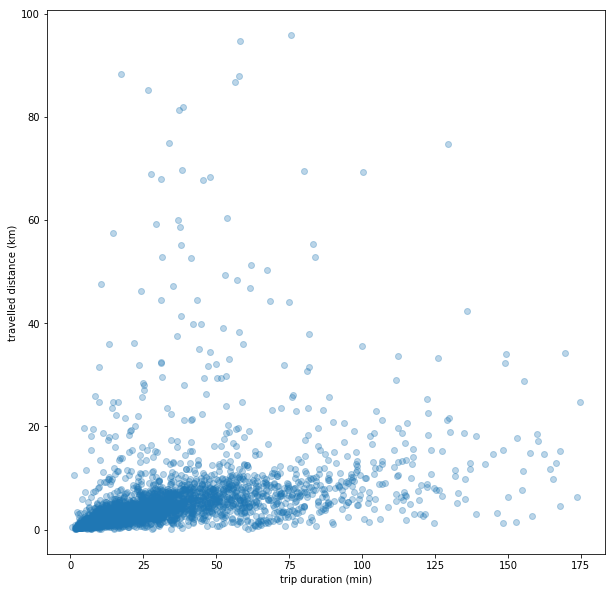


--- CATEGORY: 31


count    7.999000e+03
mean     4.222410e+03
std      3.608316e+04
min      9.886900e+01
25%      9.435580e+02
50%      1.878892e+03
75%      3.559845e+03
max      2.557297e+06
Name: total_duration, dtype: float64

count    7.999000e+03
mean     2.264331e+04
std      6.442259e+04
min      2.272827e+02
25%      2.874045e+03
50%      5.870835e+03
75%      1.431744e+04
max      1.986280e+06
Name: total_distance, dtype: float64

count    7999.000000
mean       30.571285
std        65.402577
min         0.007645
25%         7.604354
50%        11.446817
75%        21.532184
max      1122.677523
Name: avg_speed, dtype: float64

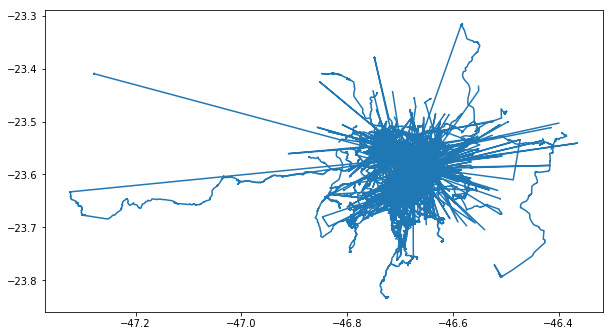

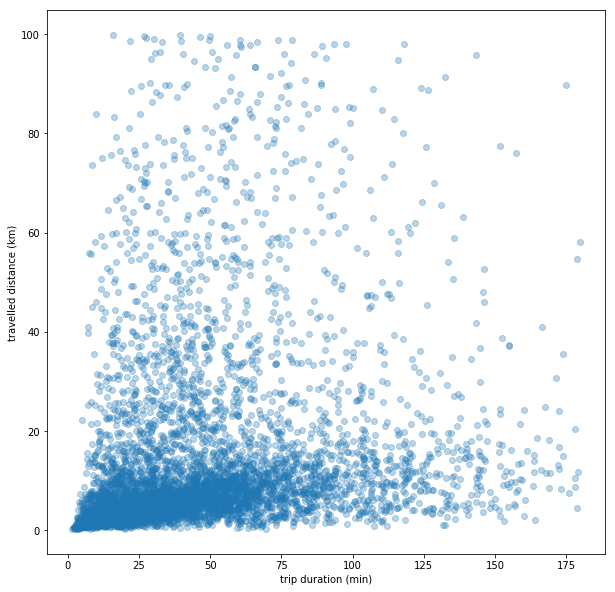

In [69]:
for idx, category in categories.iterrows():
    filtered = trip_segment_types[
        (trip_segment_types.normal_zero == category.normal_zero) &
        (trip_segment_types.normal_normal == category.normal_normal) &
        (trip_segment_types.normal_long == category.normal_long) &
        (trip_segment_types.long_zero == category.long_zero) &
        (trip_segment_types.long_normal == category.long_normal) &
        (trip_segment_types.long_long == category.long_long)
    ].merge(trips, on='tripid')
    print()
    print('--- CATEGORY:', category.category)
    
    display(filtered.total_duration.describe())
    display(filtered.total_distance.describe())
    display(filtered.avg_speed.describe())
    
    trajectories = traj.process_trajectories(filtered[filtered.avg_speed < 40])
    fig, ax = plt.subplots(figsize=(10, 10))
    trajectories.plot(ax=ax)
    plt.show()
    
    plot_filter = filtered[(filtered.total_duration < 3*60*60) & (filtered.total_distance < 100*1000)]
    plt.figure(figsize=(10, 10))
    plt.xlabel('trip duration (min)')
    plt.ylabel('travelled distance (km)')
    plt.scatter(plot_filter.total_duration/60, plot_filter.total_distance/1000, alpha=0.3)
    plt.show()